# Analyses - Figure 1, S1, S2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy.api as sc
import matplotlib as mpl
from matplotlib import rcParams

import seaborn as sns
import scipy as sci

import gseapy as gp
from xlrd import XLRDError
import xlsxwriter

/Users/sophie/miniconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.0.4+92.g9a754bb.dirty anndata==0.5.10 numpy==1.14.2 scipy==1.0.1 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.1 


In [3]:
sc.settings.writedir='./data/'
sc.settings.figdir='./figures/'

In [4]:
sc.set_figure_params(vector_friendly=True, color_map='RdBu_r', dpi_save=300)

In [5]:
adata_all = sc.read('./data/adata_processed.h5')

In [6]:
adata_all_hvg = adata_all[:, adata_all.var.highly_variable].copy()

## QC summary

In [7]:
adata_all.obs.groupby(['sample']).size()

sample
CD_1     4637
CD_2     4575
CD_3     4154
HFD_1    4345
HFD_2    5083
HFD_3    4893
dtype: int64

In [8]:
adata_all.obs[['n_counts', 'n_genes', 'sample']].groupby(['sample']).median()

n_counts  n_genes
sample                   
CD_1     16971.0   3532.0
CD_2     15920.0   3400.0
CD_3     18953.0   3788.5
HFD_1    19913.0   3839.0
HFD_2    16324.0   3225.0
HFD_3    17061.0   3499.0

## Cell densities

**note**: in new versions of scanpy this is wrapped in: sc.tl.embedding_density() and sc.pl.embedding_density()

In [9]:
def cal_density_obs(adata, obsm, obsname):

    from scipy.stats import gaussian_kde

    x = adata.obsm[obsm][:, 0]
    y = adata.obsm[obsm][:, 1]

    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    
    adata.obs[obsname+'_density'] = z

    return(adata)

In [10]:
def plot_density_obs(adata, adata_full, obsm, obsname, cmap='Greys', greysize=5, colorsize=10, colbar=False, vmax=0, vmin=0, savefile=None, dpisave=300):

    z = adata.obs[obsname+'_density']
    x = adata.obsm[obsm][:, 0]
    y = adata.obsm[obsm][:, 1]
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    fig, ax = pl.subplots()
    ax.scatter(adata_full.obsm[obsm][:, 0], adata_full.obsm[obsm][:, 1], c='lightgrey', edgecolor='', s=greysize, rasterized=True)
        
    if vmax==0:
        vmax=max(z)
    
    ax.scatter(x, y, c=z, s=colorsize, edgecolor='', cmap=cmap, vmax=vmax, vmin=vmin, rasterized=True)
    if colbar:
        fig.colorbar(i,ax=ax)
    pl.grid(b=False)
    ax.set_xticklabels([])
    ax.set_yticklabels([])    
    
    
    pl.xlabel('dim 1')
    pl.ylabel('dim 2')
    pl.xticks([])
    pl.yticks([])
    
    if savefile is not None:
        pl.savefig(savefile, dpi=dpisave, format='pdf')
    pl.show()
    return()

### split by sample/mouse

In [11]:
adata_all.obs['sample'].cat.categories

Index(['CD_1', 'CD_2', 'CD_3', 'HFD_1', 'HFD_2', 'HFD_3'], dtype='object')

CD_1


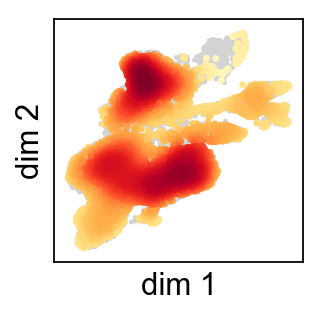

CD_2


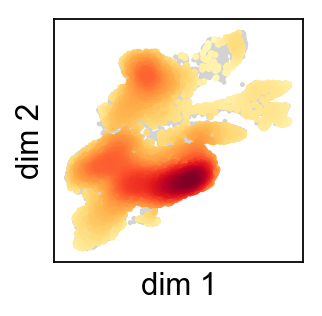

CD_3


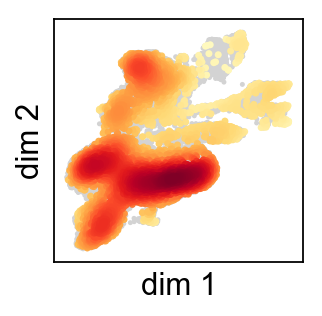

HFD_1


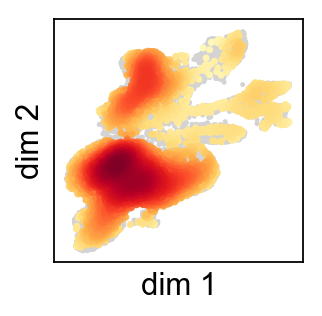

HFD_2


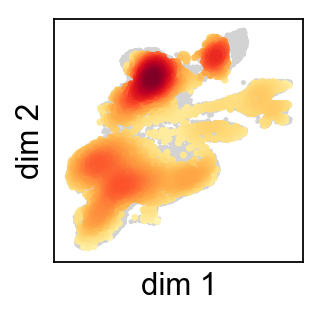

HFD_3


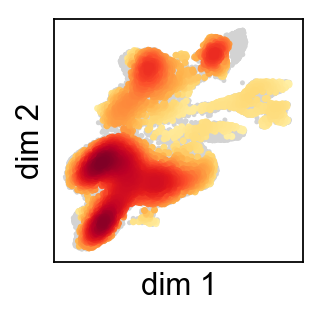

In [12]:
for smp in adata_all.obs['sample'].cat.categories:
    rcParams['figure.figsize'] = (2, 2)
    adata_sub = adata_all[adata_all.obs['sample'].isin([smp]), :].copy()
    adata_sub = cal_density_obs(adata_sub,'X_umap', 'smp')
    print(smp)
    plot_density_obs(adata_sub, adata_all, 'X_umap', 'smp', cmap='YlOrRd')

### split by condition

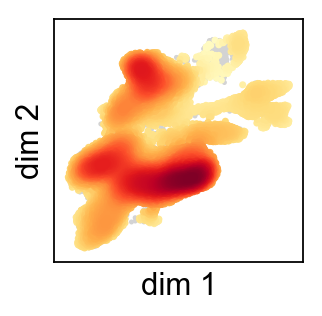

()

In [13]:
rcParams['figure.figsize'] = (2, 2)
adata_sub = adata_all[adata_all.obs['diet'].isin(['CD']), :].copy()
adata_sub = cal_density_obs(adata_sub,'X_umap', 'diet')
plot_density_obs(adata_sub, adata_all, 'X_umap', 'diet', cmap='YlOrRd')

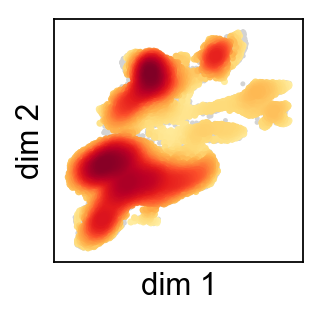

()

In [14]:
rcParams['figure.figsize'] = (2, 2)
adata_sub = adata_all[adata_all.obs['diet'].isin(['HFD']), :].copy()
adata_sub = cal_density_obs(adata_sub,'X_umap', 'diet')
plot_density_obs(adata_sub, adata_all, 'X_umap', 'diet', cmap='YlOrRd')

## Manifold

In [15]:
sc.set_figure_params(vector_friendly=True, color_map='RdBu_r', dpi_save=300)

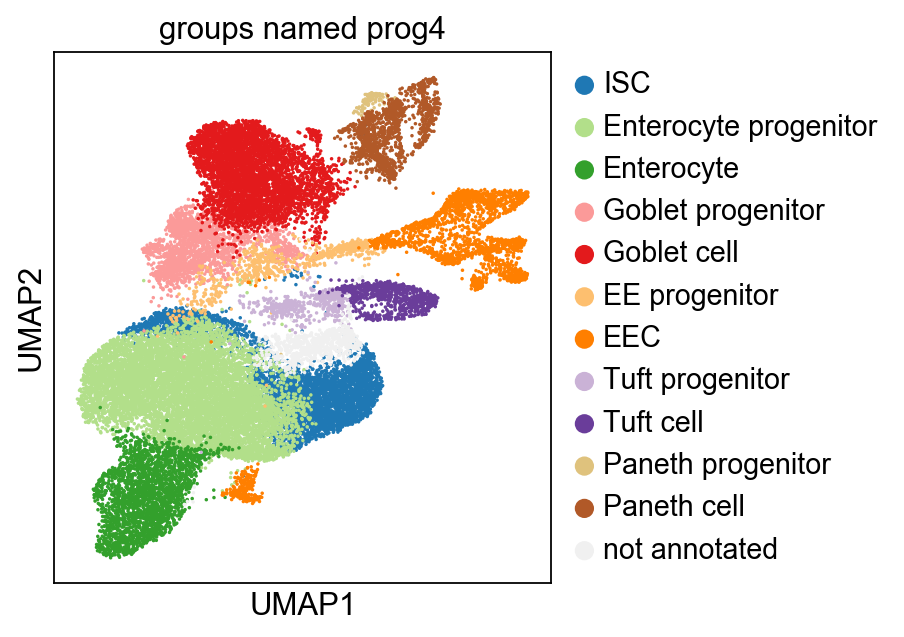

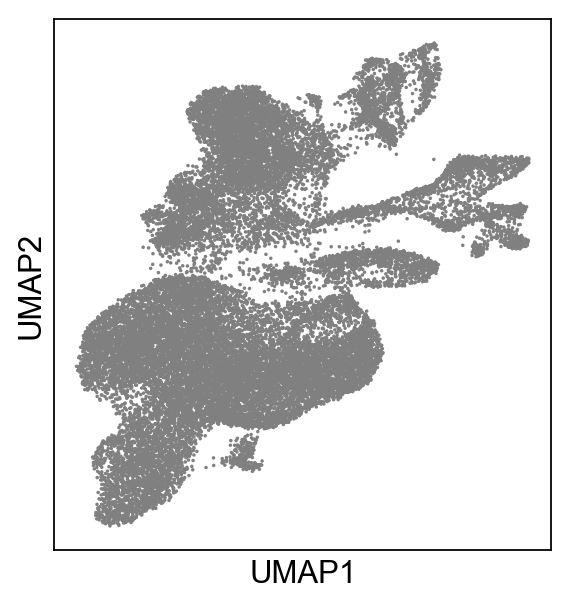

In [16]:
sc.pl.umap(adata_all, color=['groups_named_prog4'], size=10)
sc.pl.umap(adata_all, size=10, palette='lightgrey')

## Cell type composition

### Cell type frequencies

In [17]:
adata_sub = adata_all[np.invert(adata_all.obs.groups_named_prog4.isin(['Paneth progenitor', 'Paneth cell']))].copy()

In [18]:
def bar_frequency_hfd_error_vert(adata,group,celltype1,celltype2,bar_width = 0.4, savefile=None,dpisave=300):
    n_groups = len(adata.obs[group].cat.categories)

    sub_cells = np.isin(adata.obs['diet'], [celltype1])
    print(np.sum(sub_cells))
    adata_filt=adata[sub_cells,:]
    data = adata_filt.obs[[group,'sample']]
    x=data.groupby([group,'sample'])[group].size().unstack().fillna(0)
    tot=x.apply(np.sum)
    x_freq=x/tot
    x_mean=x_freq.apply(np.mean,axis=1)
    x_se=x_freq.apply(np.std,axis=1)/np.sqrt(len(np.unique(adata_filt.obs['sample'])))
    group_names = adata_filt.obs[group].cat.categories

    
    sub_cells = np.isin(adata.obs['diet'], [celltype2])
    print(np.sum(sub_cells))
    adata_filt=adata[sub_cells,:]
    data = adata_filt.obs[[group,'sample']]
    x=data.groupby([group,'sample'])[group].size().unstack().fillna(0)
    tot=x.apply(np.sum)
    x_freq_2=x/tot
    x2_mean=x_freq_2.apply(np.mean,axis=1)
    x2_se=x_freq_2.apply(np.std,axis=1)/np.sqrt(len(np.unique(adata_filt.obs['sample'])))
    
    fig, ax = pl.subplots()
    
    L = np.array(range(n_groups))
    
    index = L[::-1] 
    print(index)
    print(n_groups)
    
    
    opacity = 0.7
    ax.grid(b=None, which='major', axis='x',color='lightgrey')

    rects1 = pl.barh(index+ bar_width, x_mean[group_names]*100, bar_width,
                     alpha=opacity,
                     color='black',xerr=x_se[group_names]*100,
                     error_kw=dict(ecolor='black', lw=1, capsize=3, capthick=1),
                     label='Control')

    rects2 = pl.barh(index, x2_mean[group_names]*100, bar_width,
                     alpha=opacity,
                     color='r',xerr=x2_se[group_names]*100,
                     error_kw=dict(ecolor='black', lw=1, capsize=3, capthick=1),
                     label='HFD')
    
    ax.scatter(x_freq.iloc[:,0]*100, index+ bar_width, color='black', s=10)
    ax.scatter(x_freq.iloc[:,1]*100, index+ bar_width, color='black', s=10)
    ax.scatter(x_freq.iloc[:,2]*100, index+ bar_width, color='black', s=10)
    
    ax.scatter(x_freq_2.iloc[:,0]*100, index, color='black', s=10)
    ax.scatter(x_freq_2.iloc[:,1]*100, index, color='black', s=10)
    ax.scatter(x_freq_2.iloc[:,2]*100, index, color='black', s=10)
    
    ax.set_axisbelow(True)
    
    ax = pl.gca()
    ax.legend_ = None

    pl.ylabel('')
    pl.xlabel('%Cells')

    pl.yticks(index + bar_width / 2, group_names,fontsize=18)
    #ax.set_xticklabels(ax.xaxis.get_major_ticks(),fontsize=14)
    pl.setp(ax.get_xticklabels(), fontsize=14)
    pl.tight_layout()
    
    
    if savefile is not None:
        pl.savefig(savefile,dpi=dpisave,format='pdf')
        
        
    pl.show()
    
    return x_freq, x_freq_2, x_mean, x_se, x2_mean, x2_se

13055
13253
[9 8 7 6 5 4 3 2 1 0]
10


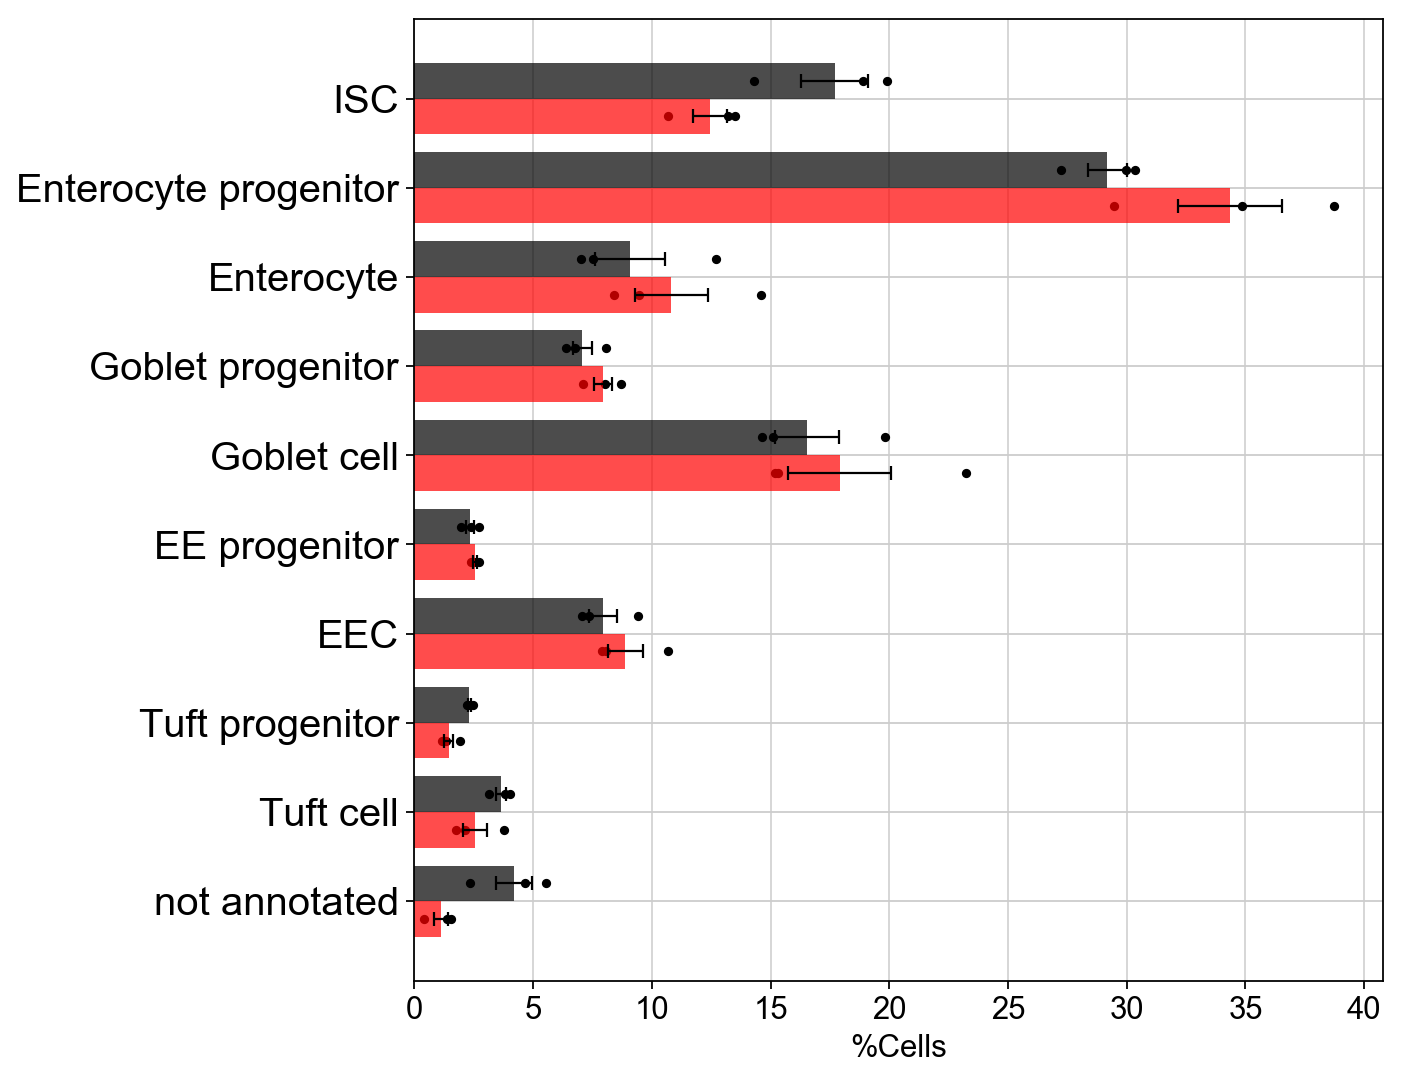

In [19]:
rcParams['figure.figsize'] = (9,7)
x_freq, x_freq_2, x_mean, x_se, x2_mean, x2_se = bar_frequency_hfd_error_vert(adata_sub, group='groups_named_prog4',celltype1='CD',celltype2='HFD',dpisave=300, savefile='figure_1e.pdf')
pl.rcParams.update(pl.rcParamsDefault)

In [20]:
df = pd.concat([x_freq, x_freq_2, x_mean, x_se, x2_mean, x2_se], axis=1, ignore_index=True)

In [21]:
x_freq.columns.tolist() + x_freq_2.columns.tolist()

['CD_1', 'CD_2', 'CD_3', 'HFD_1', 'HFD_2', 'HFD_3']

In [22]:
df.columns = ['CD_1', 'CD_2', 'CD_3', 'HFD_1', 'HFD_2', 'HFD_3', 'CD_mean', 'CD_sem', 'HFD_mean', 'HFD_sem']

In [23]:
df

CD_1      CD_2      CD_3     HFD_1     HFD_2  \
groups_named_prog4                                                        
ISC                    0.143139  0.198825  0.188837  0.132031  0.106783   
Enterocyte progenitor  0.272249  0.303660  0.299730  0.387274  0.294748   
Enterocyte             0.070145  0.075011  0.127121  0.094614  0.084245   
Goblet progenitor      0.080666  0.063940  0.067617  0.080315  0.087090   
Goblet cell            0.198378  0.151152  0.146545  0.153003  0.232385   
EE progenitor          0.023674  0.027113  0.019425  0.023832  0.027133   
EEC                    0.094038  0.070718  0.073519  0.080553  0.106783   
Tuft progenitor        0.022139  0.024853  0.022375  0.011439  0.019037   
Tuft cell              0.040114  0.037958  0.031227  0.021449  0.037856   
not annotated          0.055458  0.046769  0.023605  0.015491  0.003939   

                          HFD_3   CD_mean    CD_sem  HFD_mean   HFD_sem  
groups_named_prog4                                                       
ISC                    0.134834  0.176934  0.013996  0.124549  0.007283  
Enterocyte progenitor  0.348340  0.291880  0.008068  0.343454  0.021899  
Enterocyte             0.145754  0.090759  0.014889  0.108204  0.015523  
Goblet progenitor      0.070871  0.070741  0.004144  0.079425  0.003840  
Goblet cell            0.151772  0.165359  0.013524  0.179053  0.021775  
EE progenitor          0.025184  0.023404  0.001815  0.025383  0.000782  
EEC                    0.078895  0.079425  0.006002  0.088744  0.007375  
Tuft progenitor        0.013149  0.023123  0.000709  0.014542  0.001879  
Tuft cell              0.017384  0.036433  0.002185  0.025563  0.005109  
not annotated          0.013818  0.041944  0.007762  0.011082  0.002943

In [24]:
writer = pd.ExcelWriter('./barplots_source_data_1e.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='figure_1e')
writer.save()

## Marker Genes

### Gene Scores

In [25]:
marker_dict = {'ISC': ['Lgr5', 'Olfm4', 'Axin2', 'Ascl2', 'Slc12a2'],
               'Enterocyte': ['Fabp1','Alpi','Apoa1','Apoa4','Lct'],
               'Goblet cell': ['Muc2','Clca3','Tff3','Agr2','Spdef','Klf4','Tff3','Ccl9'],
               'Goblet progenitor': ['Spdef','Atoh1'],
               'Paneth cell': ['Lyz1','Mmp7','Defa17','Defa22','Ang4'],
               'EEC': ['Neurod1','Neurod2','Insm1','Chga','Chgb'],
               'EE progenitor': ['Sox4', 'Neurog3', 'Foxa2', 'Foxa3', 'Marcksl1'],
               'Tuft cell': ['Dclk1','Trpm5','Gfi1b','Il25']
               }

In [26]:
sc.set_figure_params(vector_friendly=True, color_map='RdBu_r', dpi_save=300)

In [27]:
%%time
for k,v in marker_dict.items():
    sc.tl.score_genes(adata_all, v, score_name=k)

computing score 'Paneth cell'
['Ap2m1', 'Dnajc15', 'Bola2', 'Nudt14', 'Ddb1', 'Arfip2', 'Naca', 'Actr3', '2210407C18Rik', 'Psma3', 'Serp1', 'C1galt1c1', 'Ptpn18', 'Wnk1', 'Usp1', 'Ssr4', 'Hn1', 'Zfos1', 'Aurkaip1', 'Rpl10-ps3', 'Hadh', 'Rps2-ps6', 'Lmna', 'Idh2', 'Manf', 'Snrnp70', 'Defa21', 'Bckdk', 'Ppp1r11', 'Hspe1', 'Fam213b', 'Gtf2a2', 'Grpel1', 'Txndc12', 'Eif4b', 'Psmb3', 'Atrx', 'Anapc11', 'Ckmt1', 'Chchd1', 'Slc1a5', 'Nxf1', 'Capzb', 'Tsc22d4', 'Ociad2', 'Aco2', 'Pnpla2', 'Cdk11b', 'Spint2', 'Ppdpf', 'Nedd4', 'Eif3e', 'Psmg1', 'Mocs2', 'AW112010', 'Cox17', 'Lamtor2', 'Mllt4', 'Fgfbp1', 'Rps5', 'Ubqln1', 'Igfbp4', 'Trappc6a', 'Pop5', 'Cisd1', 'Grcc10', 'Ngdn', 'Anp32b', 'Magt1', 'Epcam', 'Lsm5', 'Rpl10', 'Mrpl18', 'Cdc42ep5', 'Saysd1', 'Net1', 'Higd2a', 'Oaz1', 'Uqcrc2', 'Calm1', 'D10Jhu81e', 'Tceb2', 'Sys1', 'Ddx3x', 'Eif6', 'Syf2', '5330417C22Rik', 'Lsm3', 'Eif3m', 'Lta4h', 'Tbrg1', 'Eif3f', 'Rsbn1l', 'Tomm40', 'Psmd11', 'Chmp4b', 'Eif3g', 'Tmem128', 'Ifi27l2b', 'Xpnpep1', 'T

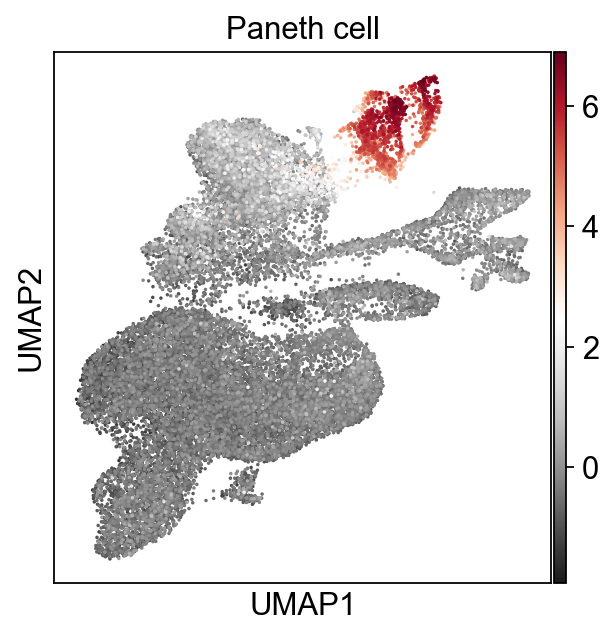

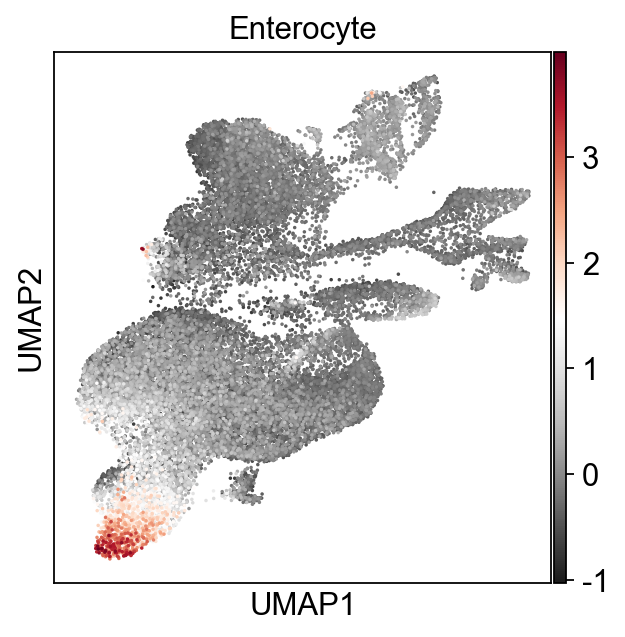

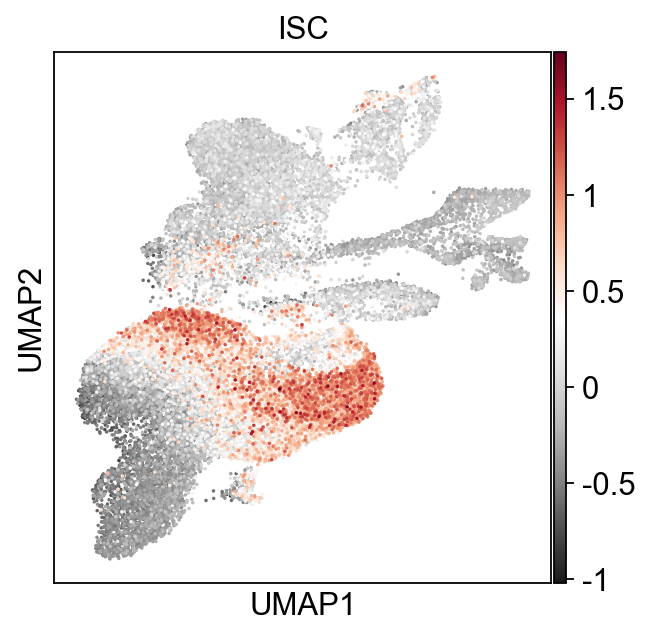

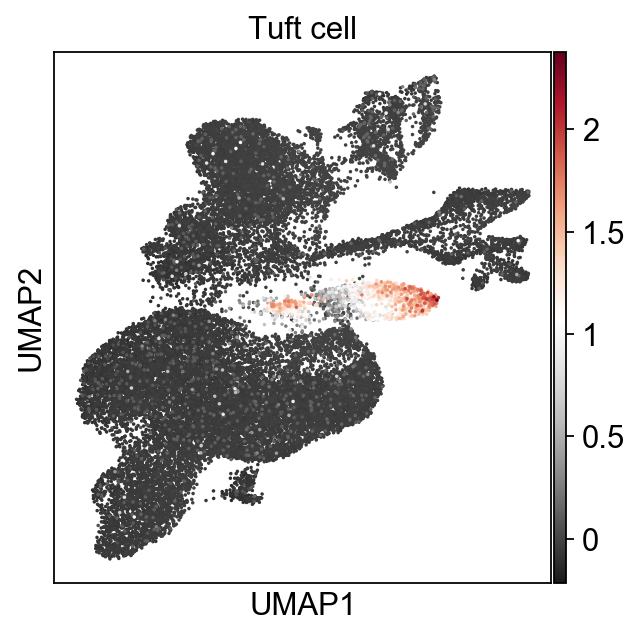

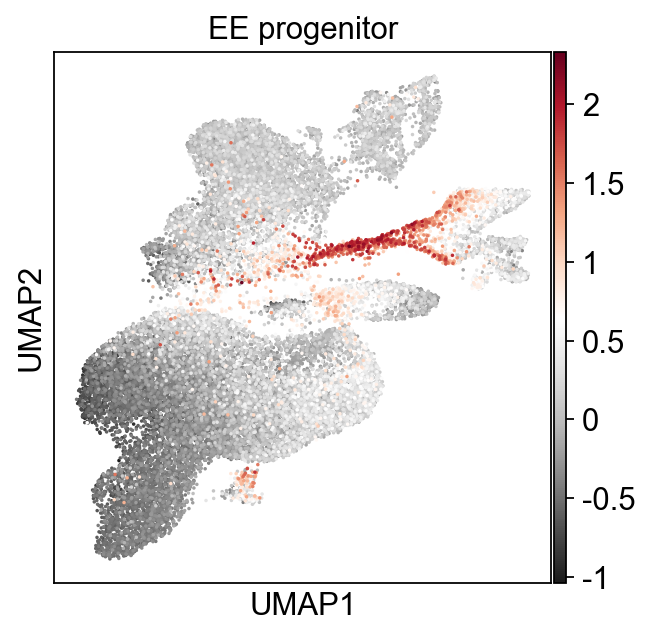

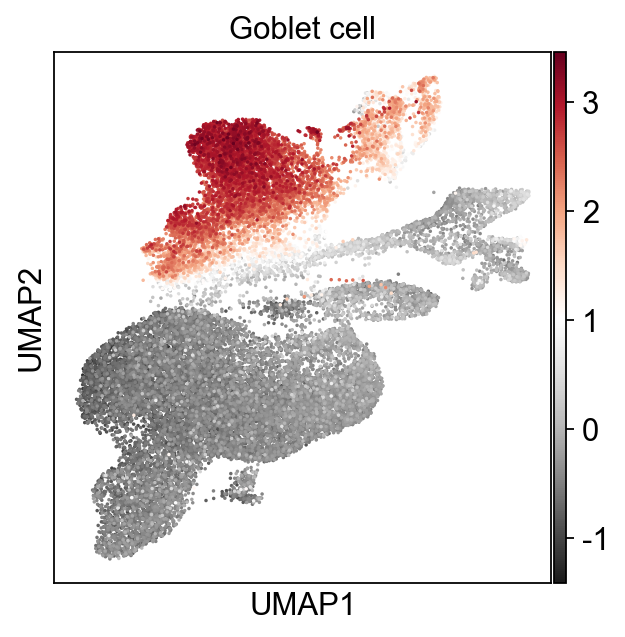

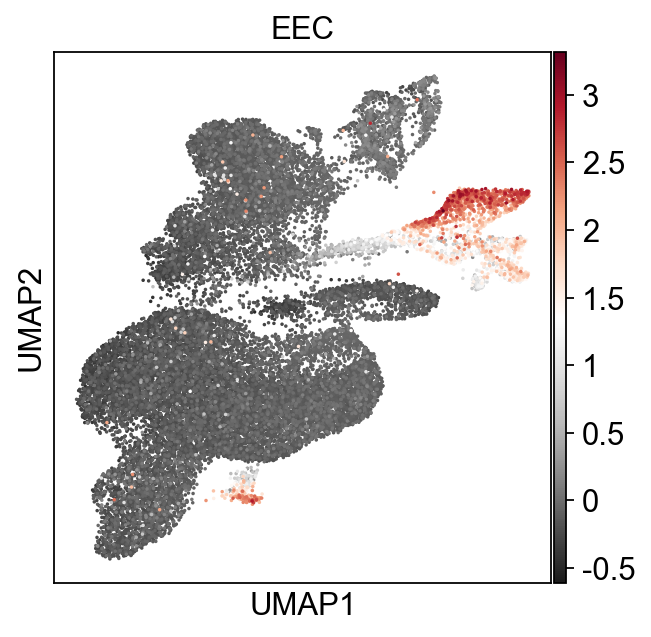

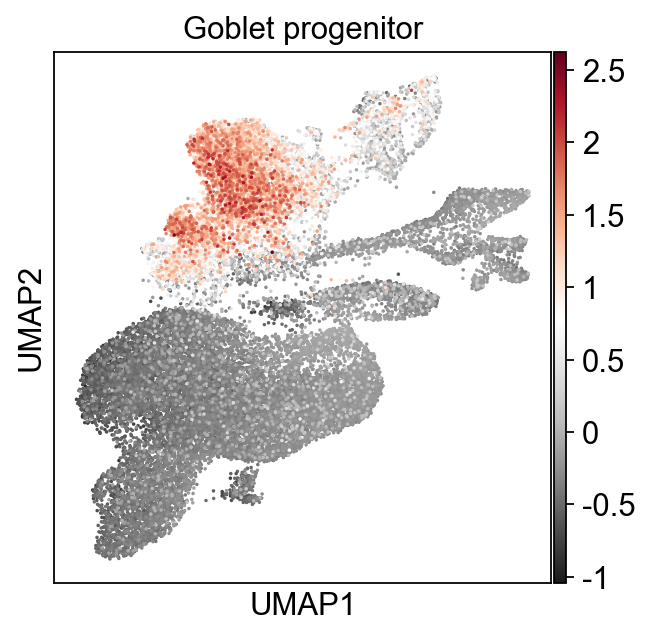

In [28]:
for k in marker_dict.keys():
    sc.pl.umap(adata_all, color=[k], size=10, color_map='RdGy_r')

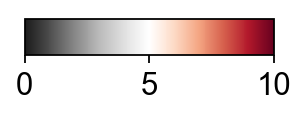

In [29]:
# plot colorbar 
fig, ax = pl.subplots(figsize=(2, 0.3))
cmap = mpl.cm.RdGy_r
norm = mpl.colors.Normalize(vmin=0, vmax=10)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
pl.show()

In [30]:
def plot_violin(adata, x, y, hue):
    
    obs_df = adata.obs[[x, y, hue]].copy()
    
    fig,ax = pl.subplots(figsize=(2,2))
    sns.violinplot(x=x, y=y, hue=hue, data=obs_df, palette=['darkgrey','red'], order=[y],
                   split=True, inner=None, scale='width', linewidth=0.1, legend=False, ax=ax)
    ax.legend_.remove()    
    pl.xticks(rotation=90)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #filename=f'./figures/celltype_scores_{y}.pdf'
    #pl.savefig(filename,dpi=600,format='pdf')
    pl.show()

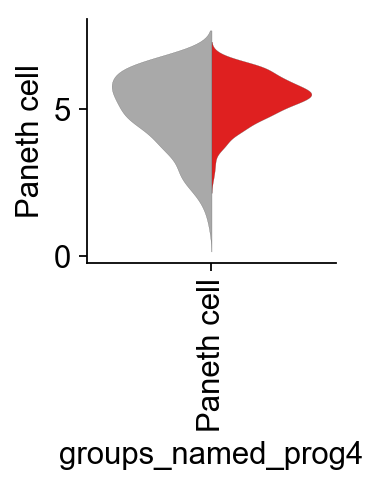

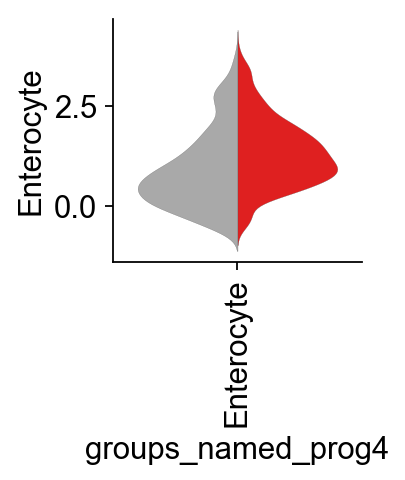

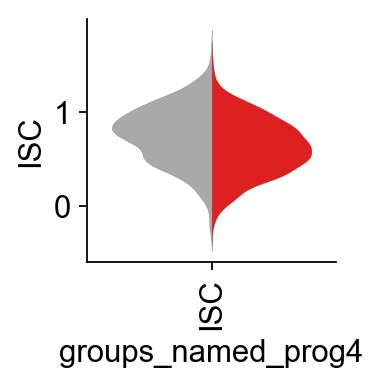

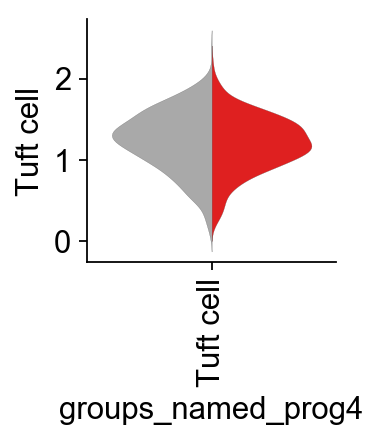

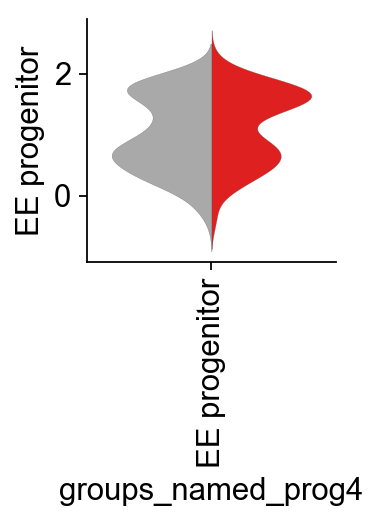

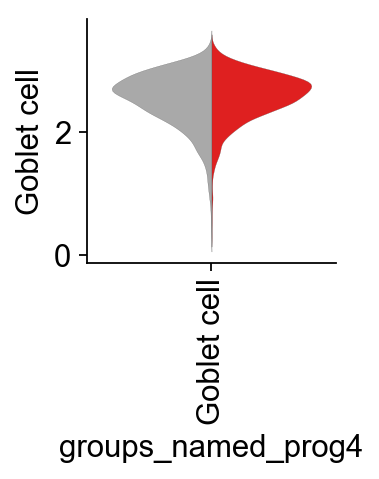

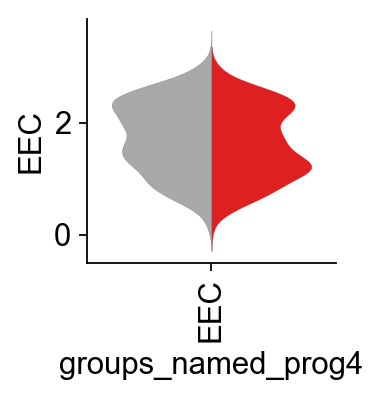

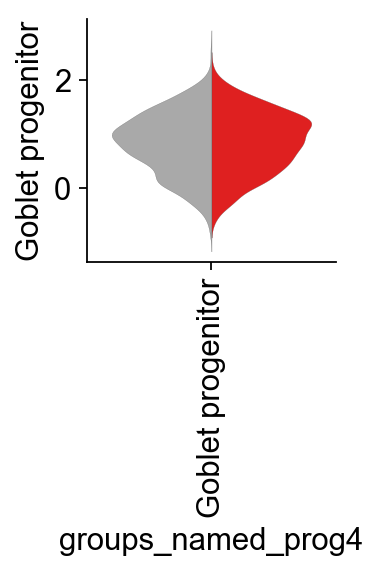

In [31]:
for k in marker_dict.keys():
    plot_violin(adata_all, 'groups_named_prog4', k, 'diet')

### Celltype specific signatures

In [32]:
ix= np.isin(adata_all.obs['diet'],['CD'])
adata_cd_raw=adata_all[ix,:].copy()

ix= np.isin(adata_all.obs['diet'],['HFD'])
adata_hfd_raw=adata_all[ix,:].copy()

exclude cell cycle genes

In [33]:
# get list of cell cycle genes from GO Term
from intermine.webservice import Service
service = Service("http://www.mousemine.org/mousemine/service")
query = service.new_query("SequenceFeature")
query.add_constraint("ontologyAnnotations.ontologyTerm", "GOTerm")
query.add_view("ontologyAnnotations.ontologyTerm.name", "primaryIdentifier", "symbol")
query.add_constraint("ontologyAnnotations.dataSets.name", "=", "GOTerm to Mouse Feature Annotations from MGI", code = "A")
query.add_constraint("organism.taxonId", "=", "10090", code = "D")
query.add_constraint("ontologyAnnotations.ontologyTerm", "LOOKUP", "GO:0007049", code = "C")

genes=list()
for row in query.rows():
    genes.append(row["symbol"])

subset to control cells for marker gene identification

In [34]:
ix_cc = np.isin(adata_cd_raw.var_names, genes)
adata_cd_raw_nocc = adata_cd_raw[:, np.invert(ix_cc)].copy()

wilcoxon test to identify marker genes

In [35]:
sc.tl.rank_genes_groups(adata_cd_raw_nocc, groupby='groups_named_prog4', method='wilcoxon')

ranking genes
    finished (0:00:19.50) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids


subset to top 50 markers with test-score >5

In [36]:
x=[]
y=[]

for i in adata_cd_raw_nocc.obs['groups_named_prog4'].cat.categories:
    group=i
    print(group)
    ix_score=adata_cd_raw_nocc.uns['rank_genes_groups']['scores'][group]>5
    try:
        if sum(ix_score)>50:
            x.extend(list(adata_cd_raw_nocc.uns['rank_genes_groups']['names'][group][ix_score][0:49]))
            y.extend(list(adata_cd_raw_nocc.uns['rank_genes_groups']['scores'][group][ix_score][0:49]))
        else:
            x.extend(list(adata_cd_raw_nocc.uns['rank_genes_groups']['names'][group][ix_score]))
            y.extend(list(adata_cd_raw_nocc.uns['rank_genes_groups']['scores'][group][ix_score]))
    except ValueError:
        print ('no significant marker genes..')
        pass
    
from collections import OrderedDict
marker_genes = list(OrderedDict.fromkeys(x))

ISC
Enterocyte progenitor
Enterocyte
Goblet progenitor
Goblet cell
EE progenitor
EEC
Tuft progenitor
Tuft cell
Paneth progenitor
Paneth cell
not annotated


#### Plot heatmaps

##### CD

In [37]:
# subset to marker genes and CD cells
adata_marker = adata_cd_raw[:, marker_genes].copy()

# compute cell type ratios for plotting
ratios= adata_marker.obs['groups_named_prog4'].value_counts()/len(adata_marker.obs['groups_named_prog4'])
ratios=ratios/min(ratios)

# scale data for plotting
adata_marker_scale = sc.pp.scale(adata_marker, max_value=4, zero_center=True, copy=True)

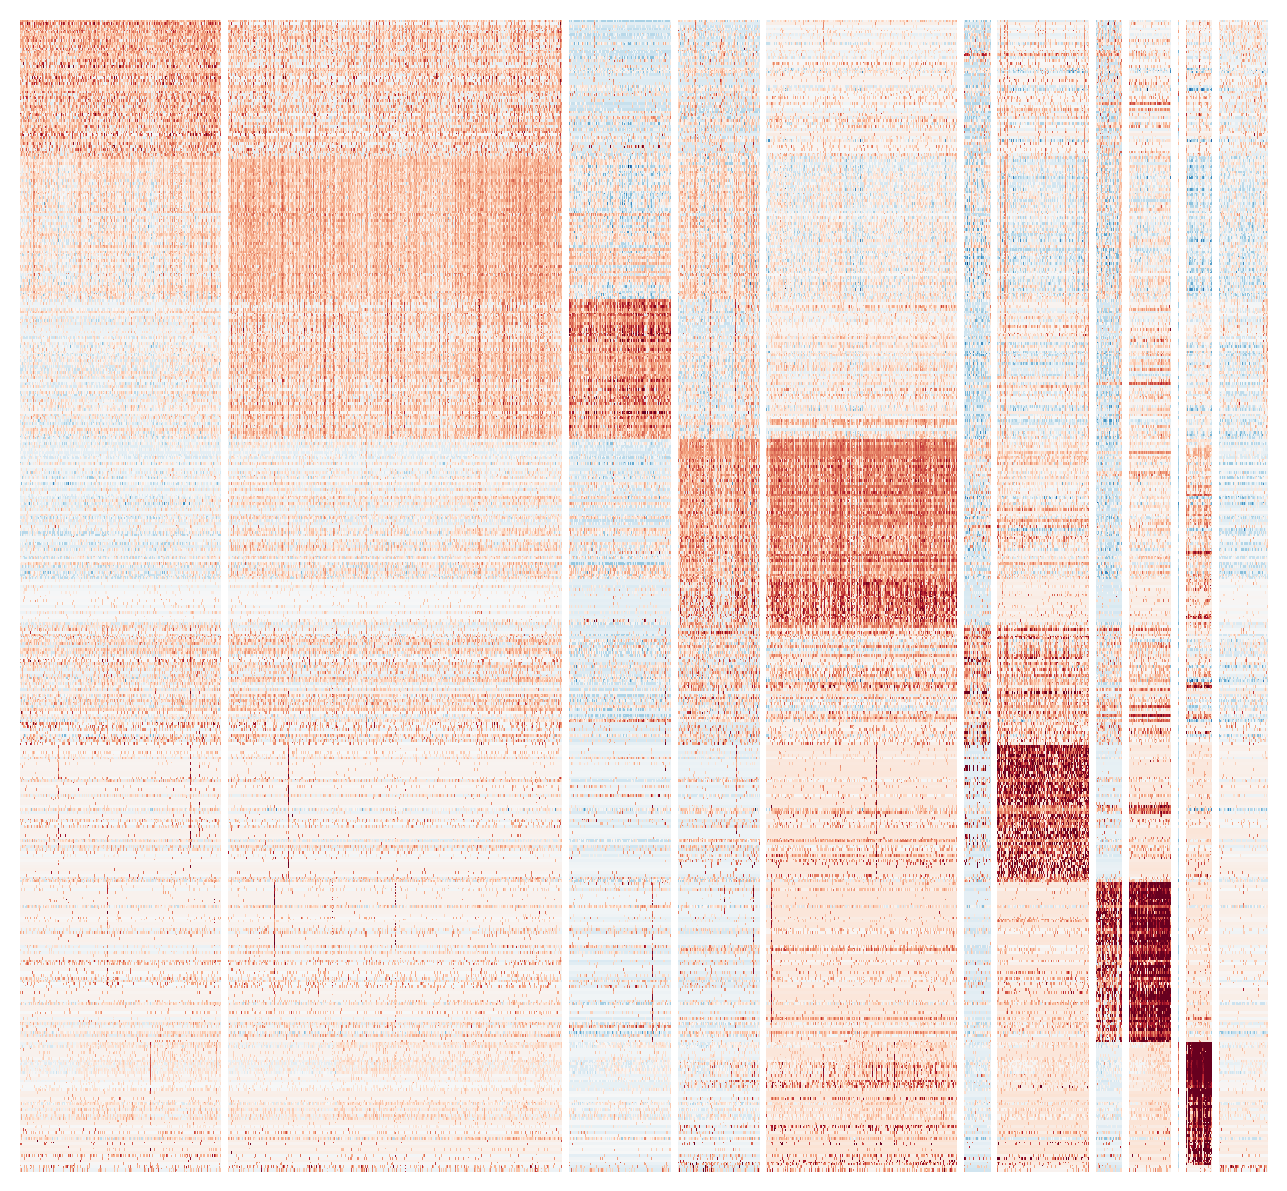

In [38]:
rcParams['figure.figsize'] = (10, 10)
rcParams['figure.subplot.top'] = 0.85
rcParams['figure.subplot.bottom'] = 0.13
_, axs = pl.subplots(ncols=12, gridspec_kw={'wspace': 0.07,'width_ratios':list(ratios[adata_marker_scale.obs.groups_named_prog4.cat.categories])})


for i,group in enumerate(adata_marker_scale.obs.groups_named_prog4.cat.categories):
    ix = np.isin(adata_marker_scale.obs.groups_named_prog4, group)
    adata_sub = adata_marker_scale[ix].copy()
    df = pd.DataFrame(adata_sub.X).T
    df.index = adata_sub.var_names
    # sort genes
    df = df.loc[marker_genes]
    sns.heatmap(df, cmap='RdBu_r', ax=axs[i], xticklabels=False, yticklabels=False, cbar=False)
    axs[i].set_ylabel('')

##### HFD

In [39]:
# subset to marker genes and HFD cells
adata_marker = adata_hfd_raw[:, marker_genes].copy()

# compute cell type ratios for plotting
ratios= adata_marker.obs['groups_named_prog4'].value_counts()/len(adata_marker.obs['groups_named_prog4'])
ratios=ratios/min(ratios)

# scale data for plotting
adata_marker_scale = sc.pp.scale(adata_marker,max_value=4,zero_center=True,copy=True)

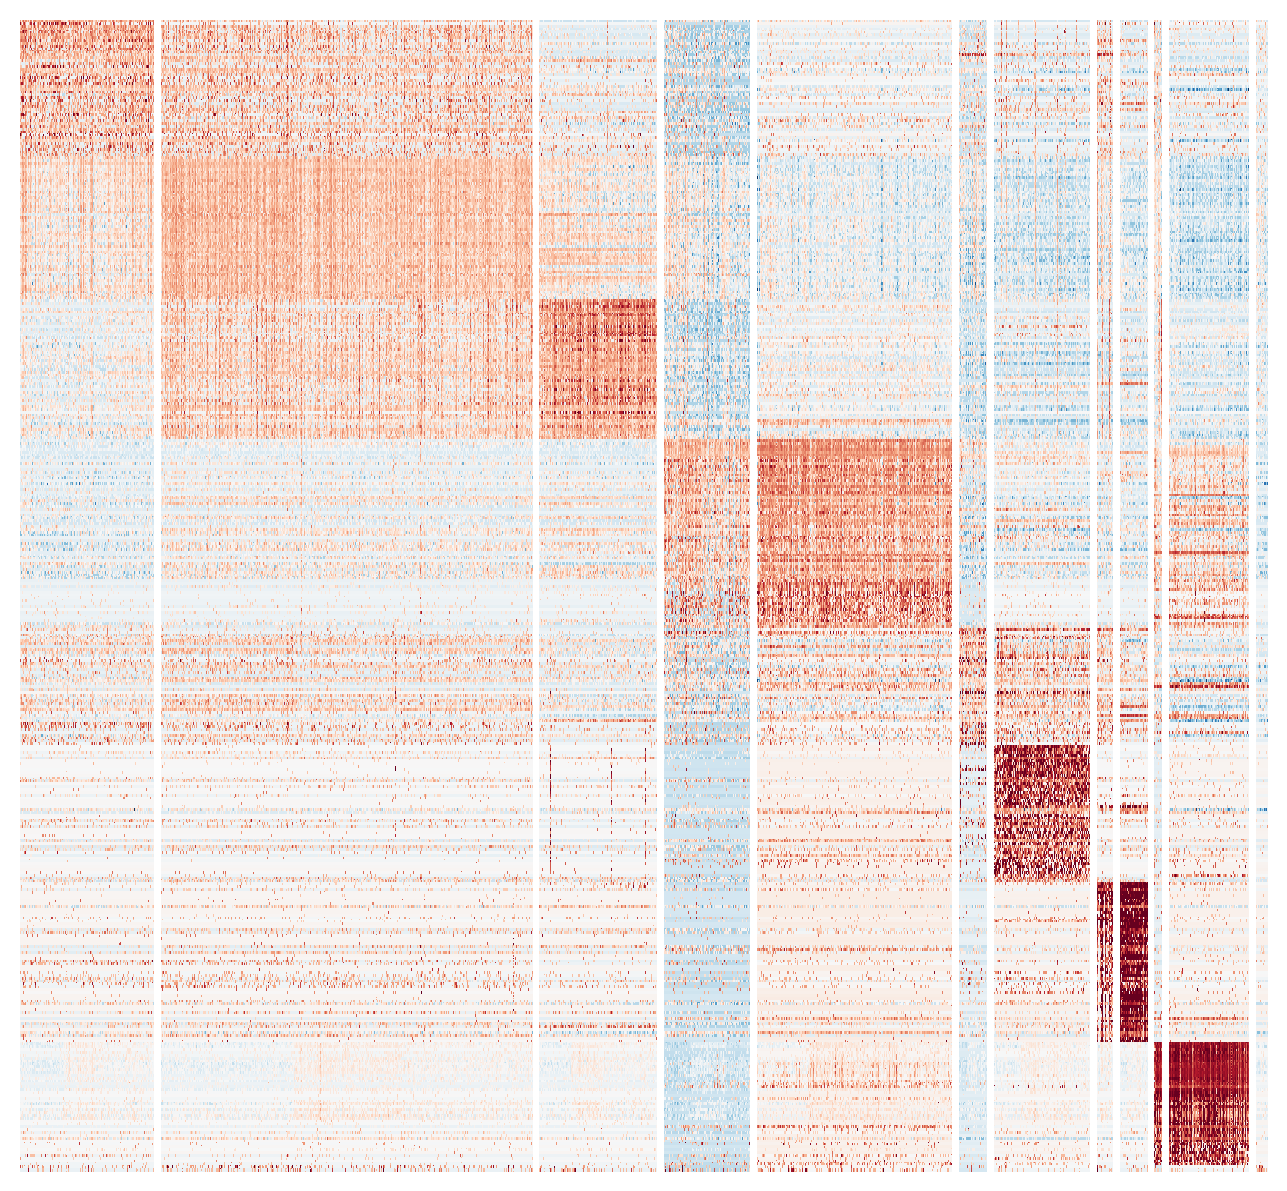

In [40]:
rcParams['figure.figsize'] = (10, 10)
rcParams['figure.subplot.top'] = 0.85
rcParams['figure.subplot.bottom'] = 0.13
_, axs = pl.subplots(ncols=12, gridspec_kw={'wspace': 0.07,'width_ratios':list(ratios[adata_marker_scale.obs.groups_named_prog4.cat.categories])})


for i,group in enumerate(adata_marker_scale.obs.groups_named_prog4.cat.categories):
    ix = np.isin(adata_marker_scale.obs.groups_named_prog4, group)
    adata_sub = adata_marker_scale[ix].copy()
    df = pd.DataFrame(adata_sub.X).T
    df.index = adata_sub.var_names
    # sort genes
    df = df.loc[marker_genes]
    sns.heatmap(df, cmap='RdBu_r', ax=axs[i], xticklabels=False, yticklabels=False, cbar=False)
    axs[i].set_ylabel('')

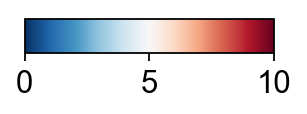

In [41]:
### plot colorbar
rcParams['figure.figsize'] = (2, 0.3)
fig, ax = pl.subplots()
cmap = mpl.cm.RdBu_r
norm = mpl.colors.Normalize(vmin=0, vmax=10)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
pl.show()

## Cell type relations

### PAGA

We need to recompute the neighbors since slicing to only the control cells also slices the knn graph, thus celly with HFD-neighbors before will now appear to be disconnected. This lowers significance of edges in the abstracted graph significantly. 

In [43]:
key='groups_named_prog4'

In [44]:
# CD
ix_cells = np.isin(adata_all_hvg.obs['diet'], ['CD'])
print(np.sum(ix_cells))
adata_cd = adata_all_hvg.copy()[ix_cells]
sc.pp.neighbors(adata_cd, n_neighbors=25, n_pcs=50, method='gauss')
sc.tl.paga(adata_cd, groups=key)

13366
computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
    finished (0:00:19.25) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
running partition-based graph abstraction (PAGA)
    finished (0:00:00.41) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/confidence', confidence adjacency (adata.uns)
    'paga/confidence_tree', confidence subtree (adata.uns)


In [45]:
# HFD
ix_cells = np.isin(adata_all_hvg.obs['diet'], ['HFD'])
print(np.sum(ix_cells))
adata_hfd=adata_all_hvg.copy()[ix_cells]
sc.pp.neighbors(adata_hfd, n_neighbors=25, n_pcs=50, method='gauss')
sc.tl.paga(adata_hfd, groups=key)

14321
computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
    finished (0:00:17.42) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
running partition-based graph abstraction (PAGA)
    finished (0:00:00.45) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/confidence', confidence adjacency (adata.uns)
    'paga/confidence_tree', confidence subtree (adata.uns)


#### plotting

exporting label positions to ./data/pos.csv


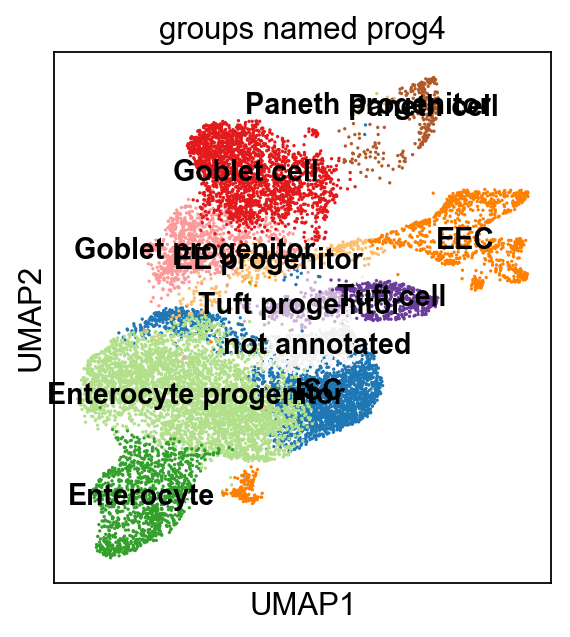

In [46]:
# get the cluster positions
sc.set_figure_params(vector_friendly=True, color_map='RdBu_r', dpi_save=300)
sc.pl.umap(adata_cd, color='groups_named_prog4', legend_loc='on data export')

In [47]:
pos = np.loadtxt('./data/pos.csv', delimiter=',')

/Users/sophie/miniconda3/lib/python3.5/site-packages/scipy/sparse/compressed.py:274: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)
/Users/sophie/miniconda3/lib/python3.5/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


--> added 'pos', the PAGA positions (adata.uns['paga'])


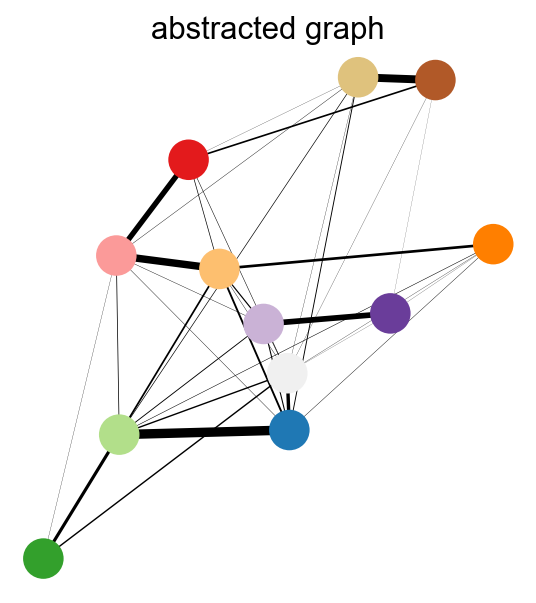

In [48]:
sc.pl.paga(adata_cd, pos=pos, node_size_power=0, frameon=False, threshold_solid=0.001, 
           edge_width_scale=5, node_size_scale=2, labels=np.array(['','','','','','','','','','','','']))

--> added 'pos', the PAGA positions (adata.uns['paga'])


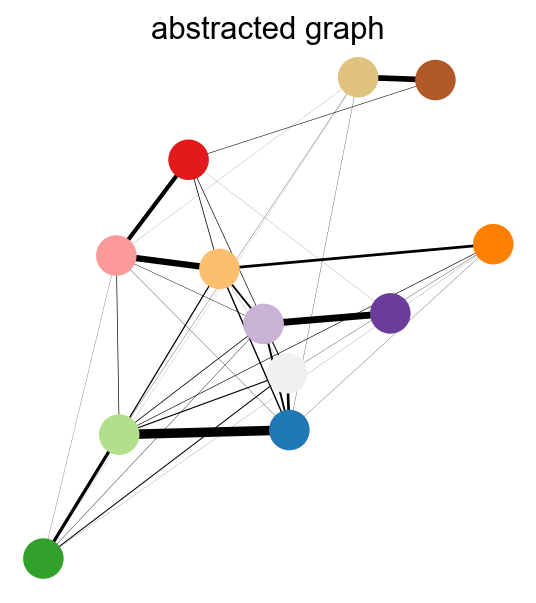

In [49]:
sc.pl.paga(adata_hfd, pos=pos, node_size_power=0, frameon=False, threshold_solid=0.001, 
           edge_width_scale=5, node_size_scale=2, labels=np.array(['','','','','','','','','','','','']))

### Cell type correlations

#### in PC space

In [50]:
sc.pp.pca(adata_all_hvg)

In [51]:
adata_cd_hvg = adata_all_hvg[adata_all_hvg.obs.diet.isin(['CD'])].copy()
adata_hfd_hvg = adata_all_hvg[adata_all_hvg.obs.diet.isin(['HFD'])].copy()

In [52]:
# compute mean PCA per group
for group in adata_cd_hvg.obs['groups_named_prog4'].cat.categories:
    adata_sub = adata_cd_hvg[adata_cd_hvg.obs.groups_named_prog4.isin([group])].copy()
    adata_cd_hvg.uns['mean_pca_'+group] = np.squeeze(np.asarray(adata_sub.obsm['X_pca'].mean(axis=0).T))

for group in adata_hfd_hvg.obs['groups_named_prog4'].cat.categories:
    adata_sub = adata_hfd_hvg[adata_hfd_hvg.obs.groups_named_prog4.isin([group])].copy()
    adata_hfd_hvg.uns['mean_pca_'+group] = np.squeeze(np.asarray(adata_sub.obsm['X_pca'].mean(axis=0).T))

In [53]:
d = dict()

for group in adata_cd_hvg.obs['groups_named_prog4'].cat.categories:
    
    d['CD_'+group] = adata_cd_hvg.uns['mean_pca_'+group]
    d['HFD_'+group] = adata_hfd_hvg.uns['mean_pca_'+group]

df = pd.DataFrame(data=d)

In [54]:
cor_pearson = np.corrcoef(df.T)
df_cor_pearson = pd.DataFrame(cor_pearson, index=df.columns, columns=df.columns)

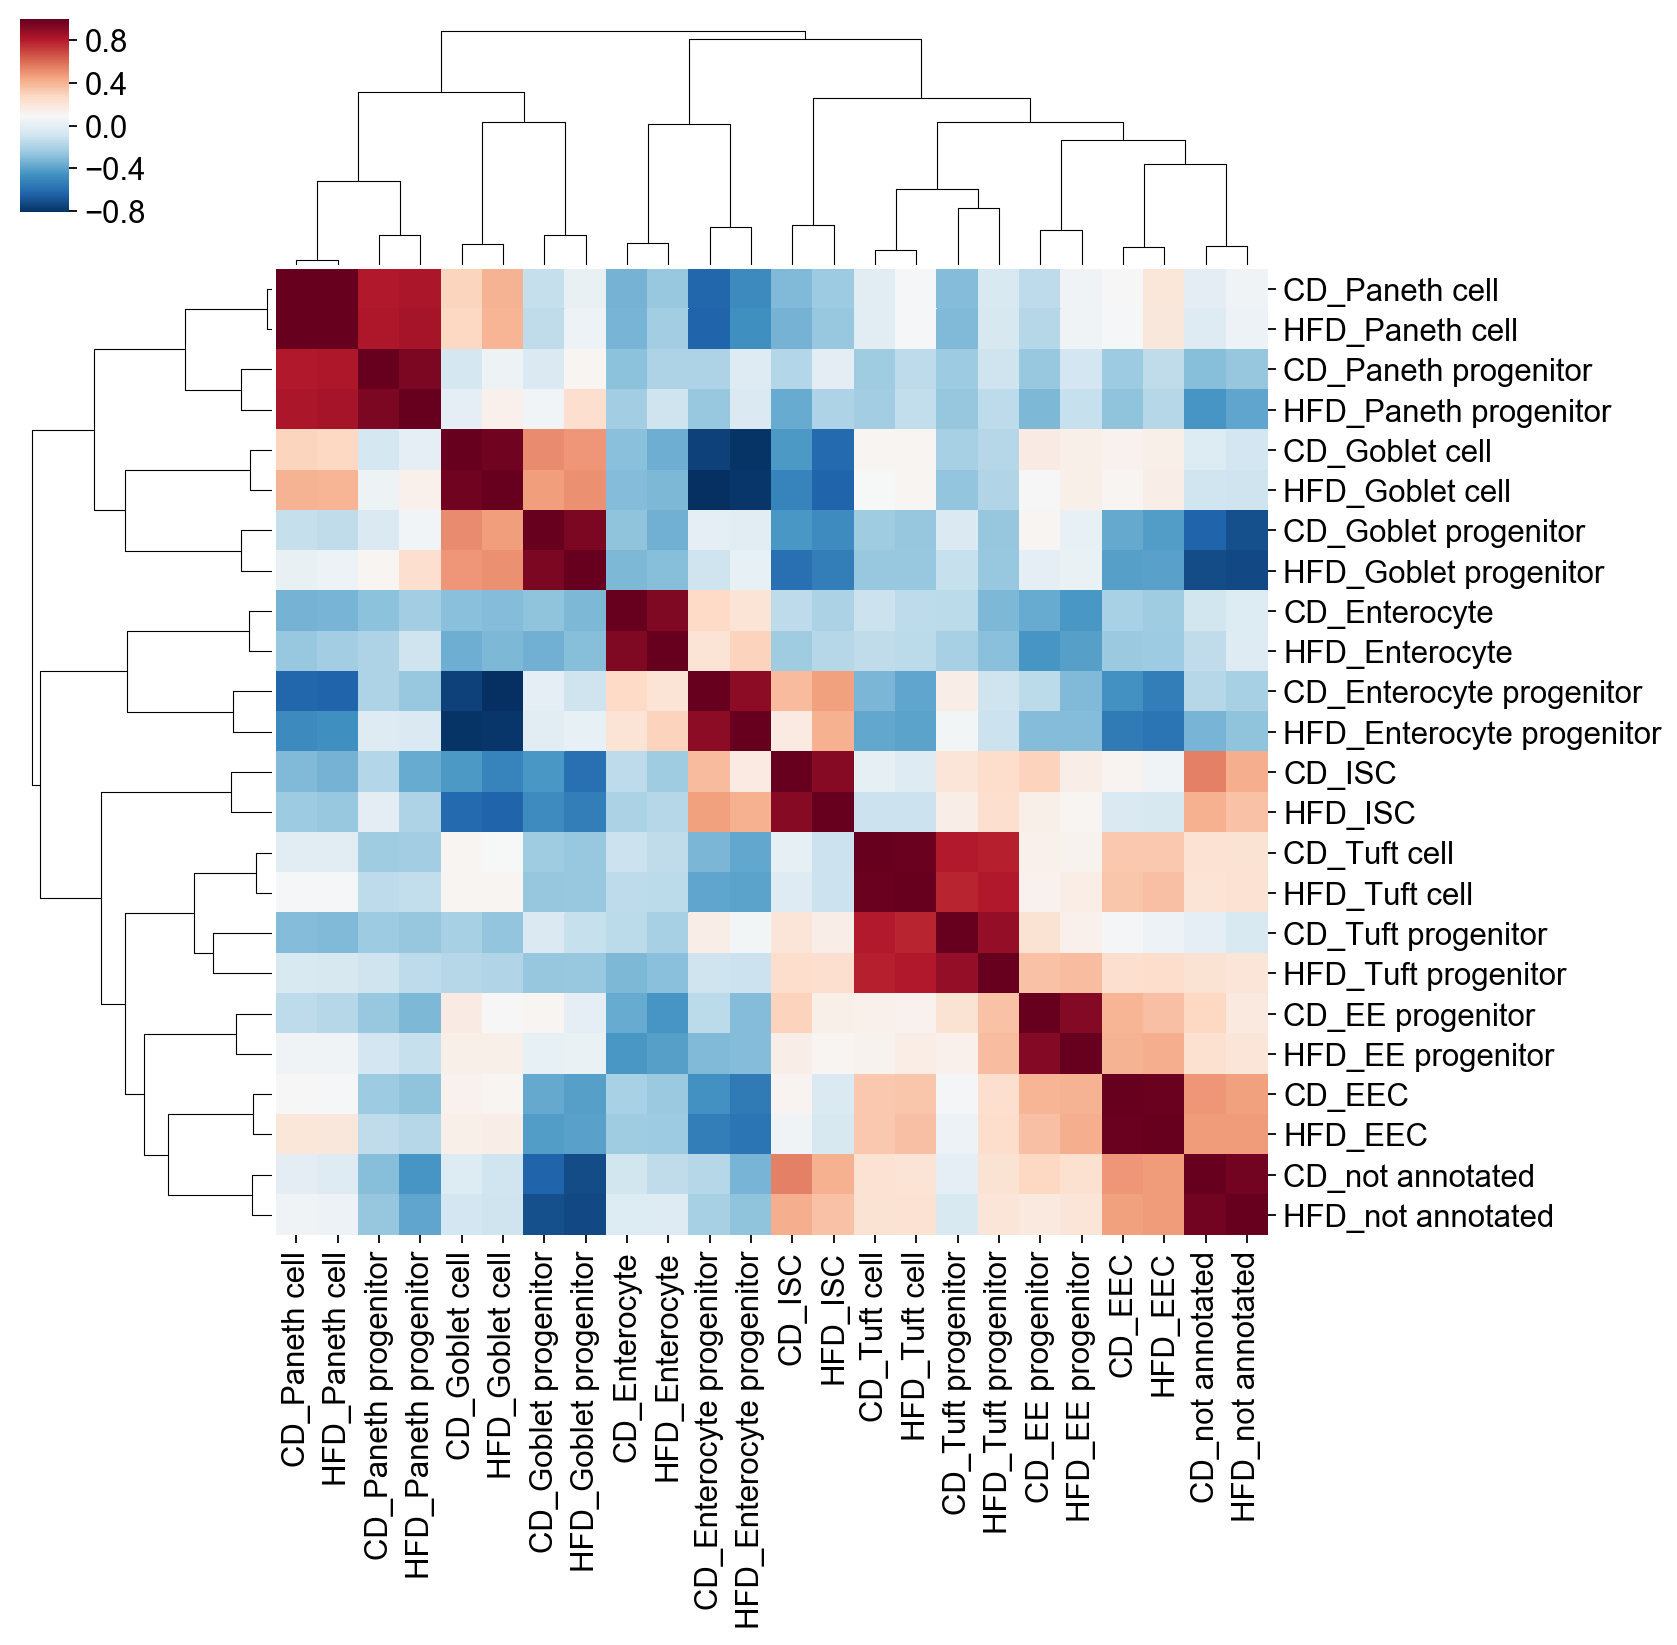

In [55]:
ax = sns.clustermap(df_cor_pearson, cmap='RdBu_r', method='average')
pl.show()

## Regionality

In [56]:
sc.set_figure_params(vector_friendly=True, color_map='RdBu_r', dpi_save=300)

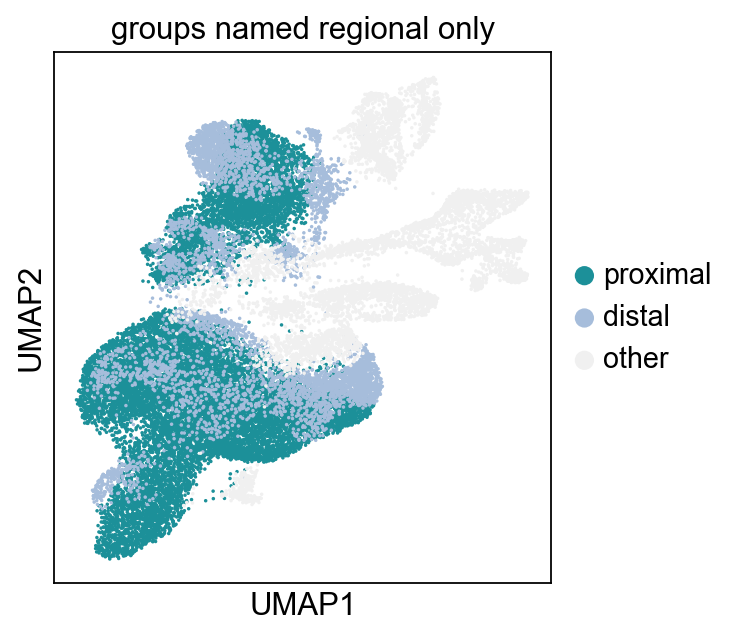

In [57]:
sc.pl.umap(adata_all_hvg, color=['groups_named_regional_only'], size=10)

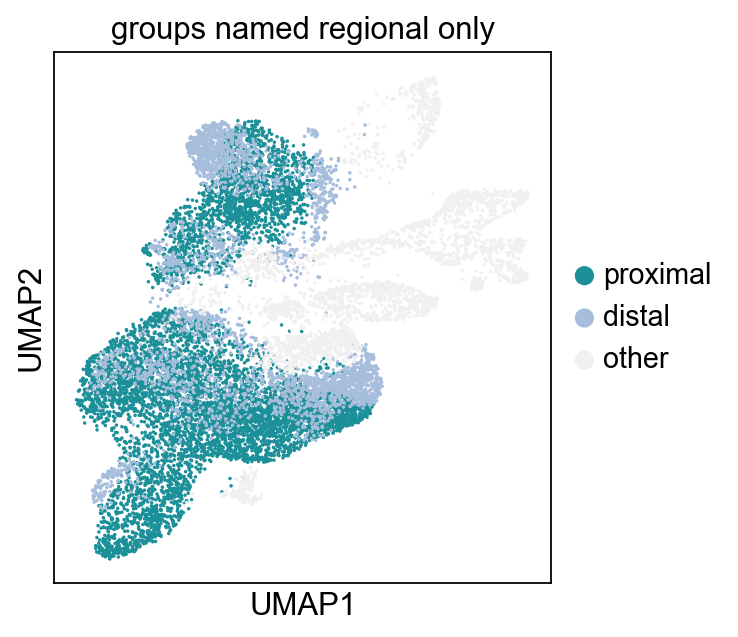

In [58]:
adata_cd = adata_all[np.isin(adata_all.obs.diet,'CD')].copy()
sc.pl.umap(adata_cd, color=['groups_named_regional_only'], size=10)

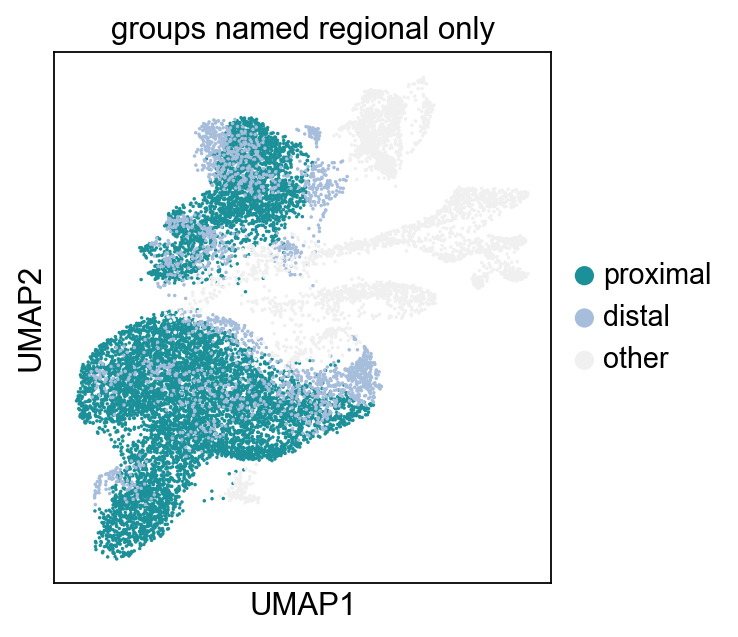

In [59]:
adata_hfd = adata_all[np.isin(adata_all.obs.diet,'HFD')].copy()
sc.pl.umap(adata_hfd, color=['groups_named_regional_only'], size=10)

### marker genes

In [60]:
adata_all_scale = adata_all.copy()
sc.pp.scale(adata_all_scale, max_value=6, zero_center=False)

/Users/sophie/code/scanpy/scanpy/preprocessing/simple.py:1008: RuntimeWarning: divide by zero encountered in true_divide
  sparsefuncs.inplace_column_scale(X, 1/scale)


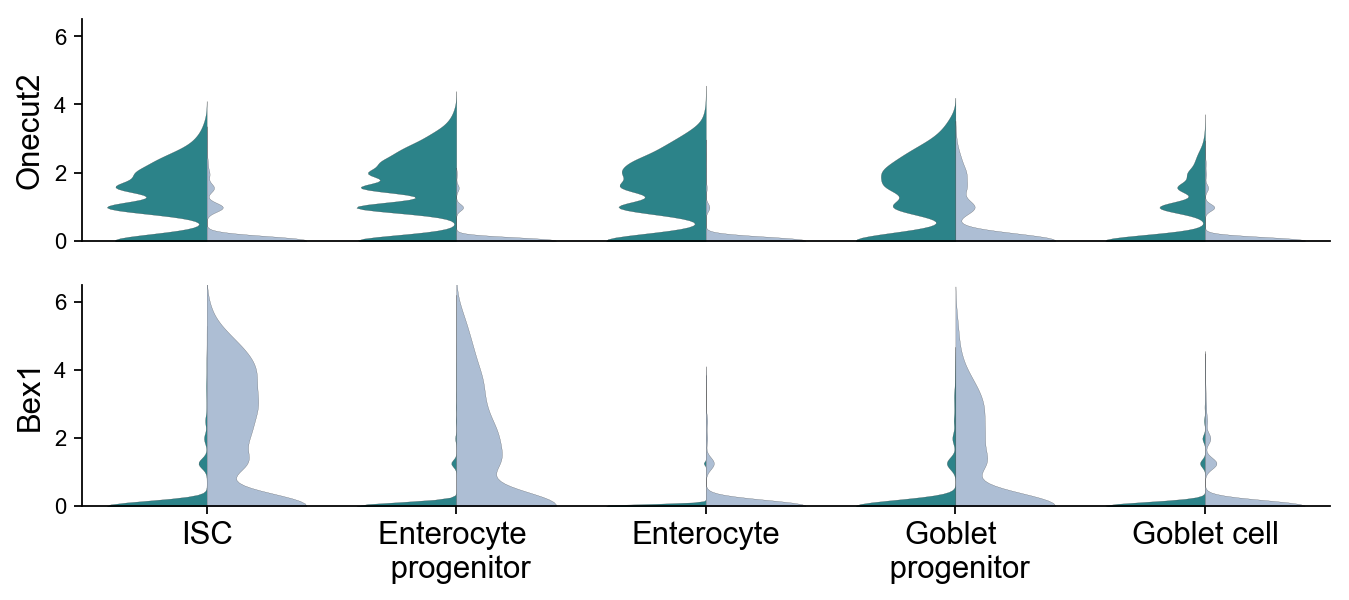

In [62]:
gene_names=['Onecut2','Bex1']

cats=['ISC', 'Enterocyte progenitor', 'Enterocyte', 'Goblet progenitor', 'Goblet cell',]
cats_names=['ISC', 'Enterocyte \n progenitor', 'Enterocyte', 'Goblet \n progenitor', 'Goblet cell']


adata_all_scale.obs['groups_named_regional_only'] = adata_all_hvg.obs['groups_named_regional_only']

adata_sub = adata_all_scale[adata_all.obs.groups_named_prog4.isin(cats)].copy()
adata_sub.obs['groups_named_prog4'].cat.remove_unused_categories()
adata_sub.obs['groups_named_regional_only'].cat.remove_unused_categories()


rcParams['figure.figsize'] = (10,4)
_, axs = pl.subplots(nrows=len(gene_names), gridspec_kw={'wspace':0.02})

for i,gene in enumerate(gene_names):
    obs_df = adata_sub.obs
    obs_df[gene] = adata_sub[:, gene].X

    sns.violinplot(x='groups_named_prog4', y=gene, hue='groups_named_regional_only', data=obs_df, 
                   split=True,scale='width',palette=['#1c9099', '#a6bddb'],ax=axs[i],linewidth=0.1,inner=None)
    axs[i].legend_.remove()
    
    if i not in [len(gene_names)-1]:
        axs[i].set_xlabel('')
        axs[i].get_xaxis().set_ticks([])
    else:
        axs[i].set_xticklabels(cats_names)

    axs[i].yaxis.label.set_size(14)
    axs[i].grid(False)
    axs[i].set_ylim([0,6.5])
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].tick_params(axis='y', which='major', labelsize=10)
    axs[i].set_xlabel('')

#pl.savefig('./figures/2F_violin_regionality.pdf",dpi=300,format=pdf')
pl.show()

### population frequencies

In [63]:
group='groups_named_prog4'

In [64]:
group_names=['ISC','Enterocyte progenitor','Enterocyte', 'Goblet progenitor', 'Goblet cell']

In [65]:
df_source_data = pd.DataFrame(index=group_names, 
                              columns=['CD_1_proximal', 'CD_2_proximal', 'CD_3_proximal', 'HFD_1_proximal', 'HFD_2_proximal', 'HFD_3_proximal', 
                                       'CD_proximal_mean', 'CD_proximal_sem', 'HFD_proximal_mean', 'HFD_proximal_sem', 
                                       'CD_1_distal', 'CD_2_distal', 'CD_3_distal', 'HFD_1_distal', 'HFD_2_distal', 'HFD_3_distal', 
                                       'CD_distal_mean', 'CD_distal_sem', 'HFD_distal_mean', 'HFD_distal_sem'])

In [66]:
# subset to CD cells   
sub_cells = np.isin(adata_all.obs['diet'], ['CD'])
print(np.sum(sub_cells))
adata_all_filt=adata_all[sub_cells].copy()

13366


In [67]:
# number of total CD cells per sample
data = adata_all_filt.obs[[group,'sample']]
tot=data.groupby([group,'sample'])[group].size().unstack().fillna(0)

In [68]:
# compute mean and SEM frequencies of distal CD cells

# subset to distal CD cells
adata_all_sub = adata_all_filt[np.isin(adata_all_filt.obs['groups_named_regional_only'],'distal')].copy()

# number of distal cells per sample
data = adata_all_sub.obs[[group,'sample','groups_named_regional_only']].copy()
x = data.groupby([group,'sample'])[group].size().unstack().fillna(0)  

# mean and sem frequency of distal cells 
x_freq=x/tot
x_mean=x_freq.apply(np.mean,axis=1)
x_se=x_freq.apply(np.std,axis=1)/np.sqrt(len(np.unique(adata_all_filt.obs['sample'])))

In [69]:
df_source_data[['CD_1_distal', 'CD_2_distal', 'CD_3_distal']] = x_freq.loc[group_names]

In [70]:
df_source_data[['CD_distal_mean']] = x_mean[group_names]

In [71]:
df_source_data[['CD_distal_sem']] = x_se[group_names]

In [72]:
# compute mean and SEM frequencies of proximal CD cells

# subset to proximal CD cells
adata_all_sub=adata_all_filt[np.isin(adata_all_filt.obs['groups_named_regional_only'],'proximal')].copy()

# number of proximal cells per sample
data = adata_all_sub.obs[[group,'sample','groups_named_regional_only']].copy()
y=data.groupby([group,'sample'])[group].size().unstack().fillna(0)  

# mean and sem frequency of proximal cells 
y_freq=y/tot  
y_mean=y_freq.apply(np.mean,axis=1)
y_se=y_freq.apply(np.std,axis=1)/np.sqrt(len(np.unique(adata_all_filt.obs['sample'])))

In [73]:
df_source_data[['CD_1_proximal', 'CD_2_proximal', 'CD_3_proximal']] = y_freq.loc[group_names]

In [74]:
df_source_data[['CD_proximal_mean']] = y_mean[group_names]

In [75]:
df_source_data[['CD_proximal_sem']] = y_se[group_names]

compute mean and SEM frequncies in control cells:

In [76]:
# subset to HFD cells   
sub_cells = np.in1d(adata_all.obs['diet'], ['HFD'])
print(np.sum(sub_cells))
adata_all_filt=adata_all[sub_cells].copy()

14321


In [77]:
# number of total HFD cells per sample
data = adata_all_filt.obs[[group,'sample']]
tot = data.groupby([group,'sample'])[group].size().unstack().fillna(0)

In [78]:
# compute mean and SEM frequencies of distal HFD cells

# subset to distal HFD cells
adata_all_sub=adata_all_filt[np.isin(adata_all_filt.obs['groups_named_regional_only'],'distal')].copy()

# number of distal HFD cells per sample
data = adata_all_sub.obs[[group,'sample','groups_named_regional_only']].copy()
x = data.groupby([group,'sample'])[group].size().unstack().fillna(0)

# mean and sem frequency of distal HFD cells 
x_freq=x/tot
x2_mean=x_freq.apply(np.mean,axis=1)
x2_se=x_freq.apply(np.std,axis=1)/np.sqrt(len(np.unique(adata_all_filt.obs['sample'])))

In [79]:
df_source_data[['HFD_1_distal', 'HFD_2_distal', 'HFD_3_distal']] = x_freq.loc[group_names]

In [80]:
df_source_data[['HFD_distal_mean']] = x2_mean[group_names]

In [81]:
df_source_data[['HFD_distal_sem']] = x2_se[group_names]

In [82]:
# compute mean and SEM frequencies of proximal HFD cells

# subset to proximal HFD cells    
adata_all_sub=adata_all_filt[np.isin(adata_all_filt.obs['groups_named_regional_only'],'proximal')].copy()

# number of proximal HFD cells per sample
data = adata_all_sub.obs[[group,'sample','groups_named_regional_only']].copy()
y = data.groupby([group,'sample'])[group].size().unstack().fillna(0)

# mean and sem frequency of proximal HFD cells 
y_freq=y/tot
y2_mean=y_freq.apply(np.mean,axis=1)
y2_se=y_freq.apply(np.std,axis=1)/np.sqrt(len(np.unique(adata_all_filt.obs['sample'])))

In [83]:
df_source_data[['HFD_1_proximal', 'HFD_2_proximal', 'HFD_3_proximal']] = y_freq.loc[group_names]

In [84]:
df_source_data[['HFD_proximal_mean']] = y2_mean[group_names]

In [85]:
df_source_data[['HFD_proximal_sem']] = y2_se[group_names]

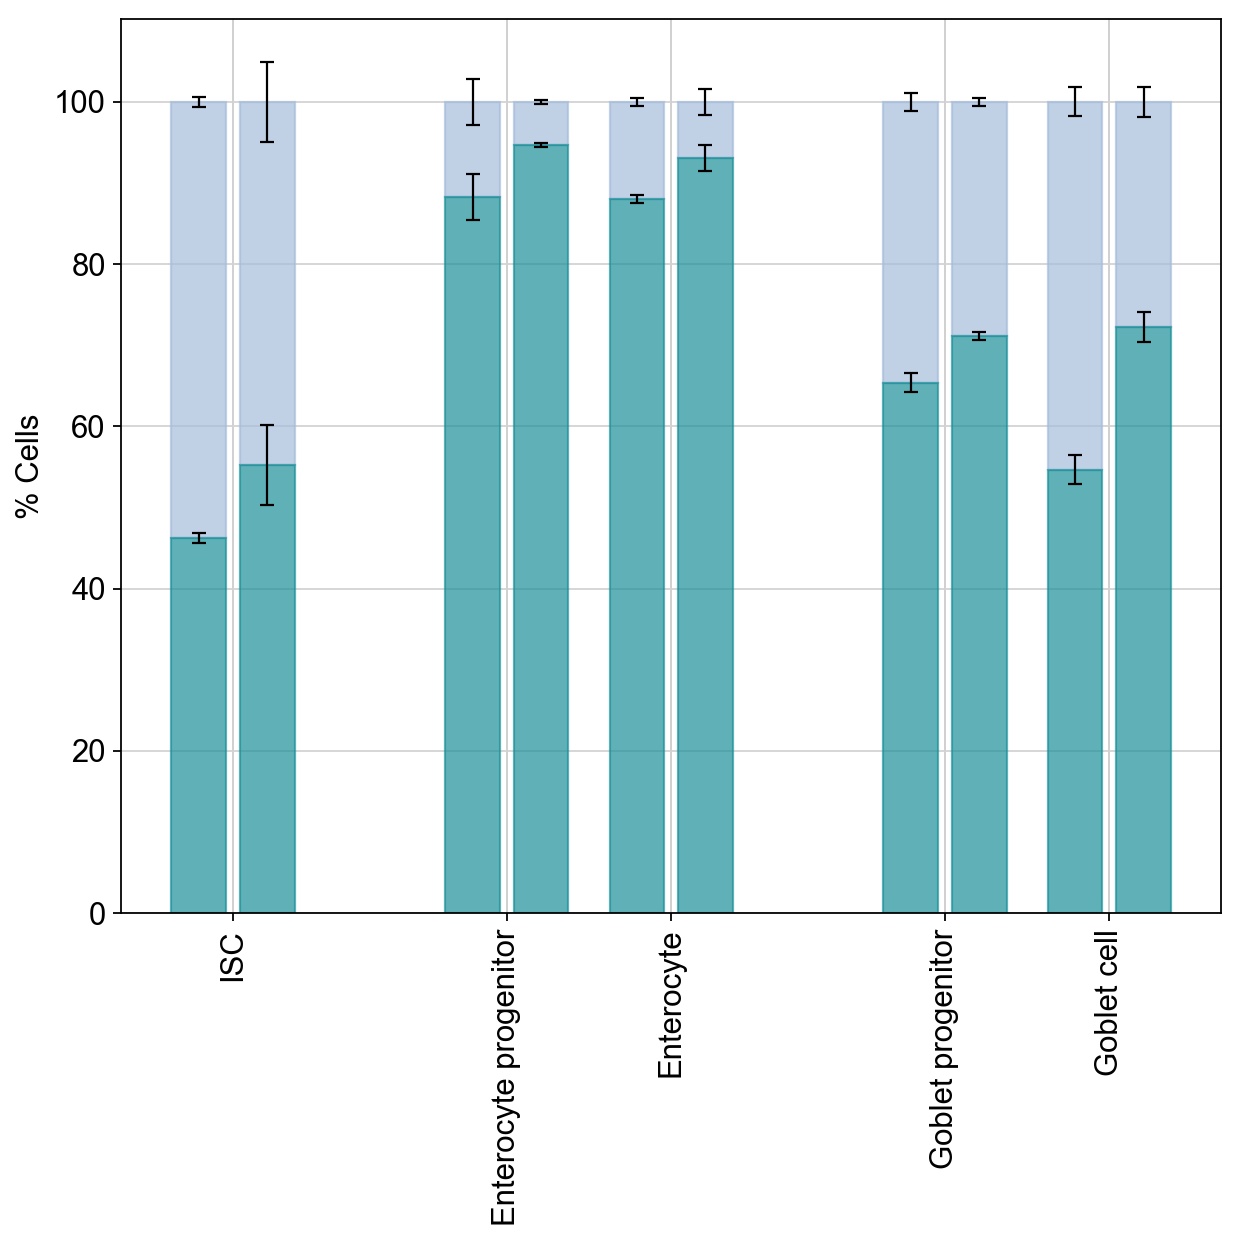

In [86]:
fig, ax = pl.subplots(figsize=(8,8))


opacity = 0.7
opacity2 = 0.7

ax.grid(b=None, which='major', axis='y',color='lightgrey')

index = np.array([1,3,4.2,6.2,7.4])
bar_width = 0.4

rects1 = pl.bar(index, x_mean[group_names]*100, bar_width, 
                color='#a6bddb',edgecolor='#a6bddb', alpha=opacity,
                yerr=x_se[group_names]*100, bottom=y_mean[group_names]*100,
                error_kw=dict(ecolor='black', lw=1, capsize=3, capthick=1),
                label='CD distal')

rects2 = pl.bar(index + bar_width+0.1, x2_mean[group_names]*100, bar_width,
                color='#a6bddb',edgecolor='#a6bddb', alpha=opacity,
                yerr=x2_se[group_names]*100, bottom=y2_mean[group_names]*100,
                error_kw=dict(ecolor='black', lw=1, capsize=3, capthick=1),
                label='HFD distal')
    
    
rects1 = pl.bar(index, y_mean[group_names]*100, bar_width,
                alpha=opacity2, edgecolor='#1c9099', color='#1c9099',
                yerr=y_se[group_names]*100,
                error_kw=dict(ecolor='black', lw=1, capsize=3, capthick=1),
                label='CD proximal')

rects2 = pl.bar(index + bar_width+0.1, y2_mean[group_names]*100, bar_width,
                alpha=opacity2, edgecolor='#1c9099', color='#1c9099',
                yerr=y2_se[group_names]*100,
                error_kw=dict(ecolor='black', lw=1, capsize=3, capthick=1),
                label='HFD proximal')

ax.set_axisbelow(True)
pl.ylim(bottom=0)
pl.xlabel('')
pl.ylabel('% Cells')
pl.xticks(index + (bar_width+0.1)/2,group_names,rotation=90,fontsize=14)
pl.tight_layout()
    
#pl.savefig('./figure/barplot_frequencies.pdf', dpi=300, format='pdf')
pl.show()

In [87]:
writer = pd.ExcelWriter('./barplots_source_data_1g.xlsx', engine='xlsxwriter')
df.to_excel(writer)
writer.save()

### Differential expression of functional markers

selected functional marker genes of proximal and distal enterocytes

In [88]:
genes_prox = [
    'Slc5a1', 'Slc2a2', 'Slc2a5', 'Mgam', 'Sis', 'Lct','G6pc',
    'Fbp1', 'Gapdh', 'Pgk1', 'Aldob', 'Pkm', 'Ldha', 'Cyc1',
    'Cox5b', 'Cox7b', 'Cox6b1', 'Atp5a1', 'Ndufa1', 'Sdha', 'Uqcrq',
    'Slc43a2', 'Slc7a8', 'Slc1a3', 'Fabp1', 'Pla2g12a',
    'Apoa1', 'Apoc3', 'Apoa4', 'Npc1l1', 'Abcg8', 'Mttp',
    'Slc11a2', 'Fth1', 'S100g','Pdxk','Rbp2'
]

In [89]:
genes_dist = [
    'Slc10a2', 'Fabp6','Mpst', 'Tst', 'Ethe1', 'Sqrdl',
    'Suox', 'Papss1','Cubn', 'Amn', 'Gpx2', 'Gclc', 'Gss',
    'Gsr', 'Gsta3', 'Gsta4'
]


load fold-changes from differential expression btw proximal and distal enterocytes in CD mice. See Differential expression notebook

In [90]:
lfc_prox = pd.read_excel('./differential_expression/CD_regionality_genes_final.xlsx', sheet_name='Enterocyte_proximal_up', index=0).set_index('index')[['logFC']]
lfc_dist = pd.read_excel('./differential_expression/CD_regionality_genes_final.xlsx', sheet_name='Enterocyte_proximal_down', index=0).set_index('index')[['logFC']]

In [91]:
lfc_prox_sel = lfc_prox.loc[genes_prox]
lfc_dist_sel = lfc_dist.loc[genes_dist]

build colormap using regional colors

In [92]:
import matplotlib.colors

x,y,c = zip(*np.random.rand(30,3)*4-2)

cmap_cst = mpl.colors.LinearSegmentedColormap.from_list("", ['#899cb7',"white",'#10666e'])#['#a6bddb',"white",'#1c9099']

norm=pl.Normalize(-2,2)
# pl.scatter(x,y,c=c, cmap=cmap_cst, norm=norm)
# pl.colorbar()
# pl.show()

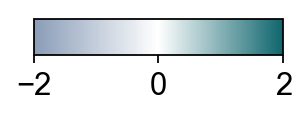

In [93]:
### plot colorbar
rcParams['figure.figsize'] = (2, 0.3)
fig, ax = pl.subplots()
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap_cst, norm=norm, orientation='horizontal')
pl.show()

plot foldchanges of proximal markers in proximal vs. distal enterocytes of CD mice

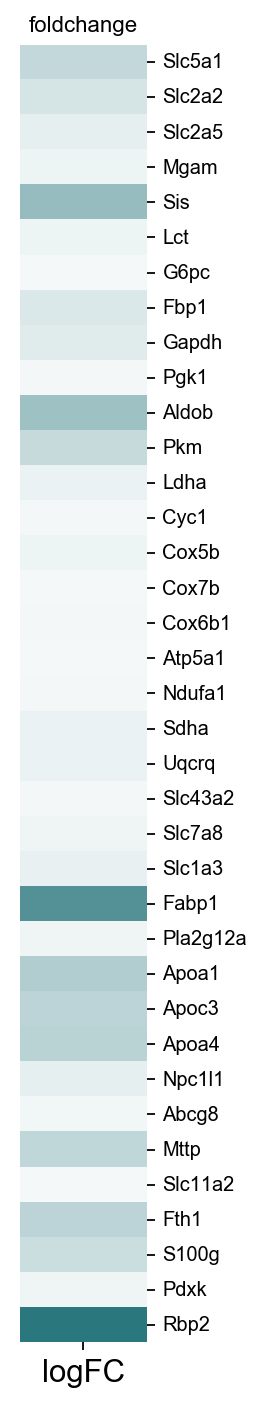

In [96]:
fig, axs = pl.subplots(figsize=(2.1,9))

sns.heatmap(lfc_prox_sel, cmap=cmap_cst, ax=axs, vmin=-3, vmax=3, center=0, cbar=None, yticklabels=1)

axs.set_title('foldchange', fontsize=10)
axs.set_ylabel('')
axs.set_yticklabels(list(genes_prox),fontdict={'verticalalignment': 'center', 'rotation':0, 'fontsize':9})
axs.yaxis.tick_right()
fig.tight_layout(rect=[0, 0, .9, 1])

#pl.savefig('./figures/S2_Regional_differences_prox.pdf',dpi=600,format='pdf')
pl.show()

plot foldchanges of distal markers in proximal vs. distal enterocytes of CD mice

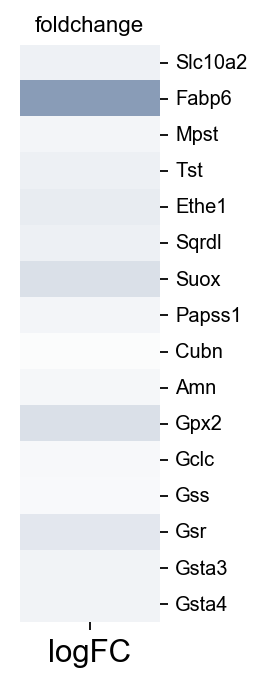

In [97]:
fig, axs = pl.subplots(figsize=(2.1,4.5))

sns.heatmap(lfc_dist_sel, cmap=cmap_cst, ax=axs, vmin=-3, vmax=3, center=0, cbar=None, yticklabels=1)

axs.set_title('foldchange', fontsize=10)
axs.set_ylabel('')
axs.set_yticklabels(list(genes_dist),fontdict={'verticalalignment': 'center','rotation':0,'fontsize':9})

fig.tight_layout(rect=[0, 0, .9, 1])
axs.yaxis.tick_right()

#pl.savefig('./figures/S2_Regional_differences_dist.pdf',dpi=600,format='pdf')
pl.show()

pl.rcParams.update(pl.rcParamsDefault)

## Lineage decision regulators

load differential expression results, see differential expression notebooks. Corresponds to Table S1.

In [98]:
filename = './differential_expression/Supplementary Table 1.xlsx'

In [99]:
cats = ['ISC', 'Enterocyte progenitor', 'Enterocyte', 'Goblet progenitor', 'Goblet cell', 'EE progenitor', 'EEC']

In [100]:
gene_names = ['Notch1', 'Notch2', 'Atoh1', 'Dll1', 'Dll4', 'Jag1', 'Sox9', 'Gfi1', 'Spdef', 'Neurog3', 'Neurod1', 'Yap1', 'Tead1']

In [101]:
# scale for plotting
# adata_all_scale = adata_all.copy()
# sc.pp.scale(adata_all_scale, max_value=6, zero_center=False)

/Users/sophie/miniconda3/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


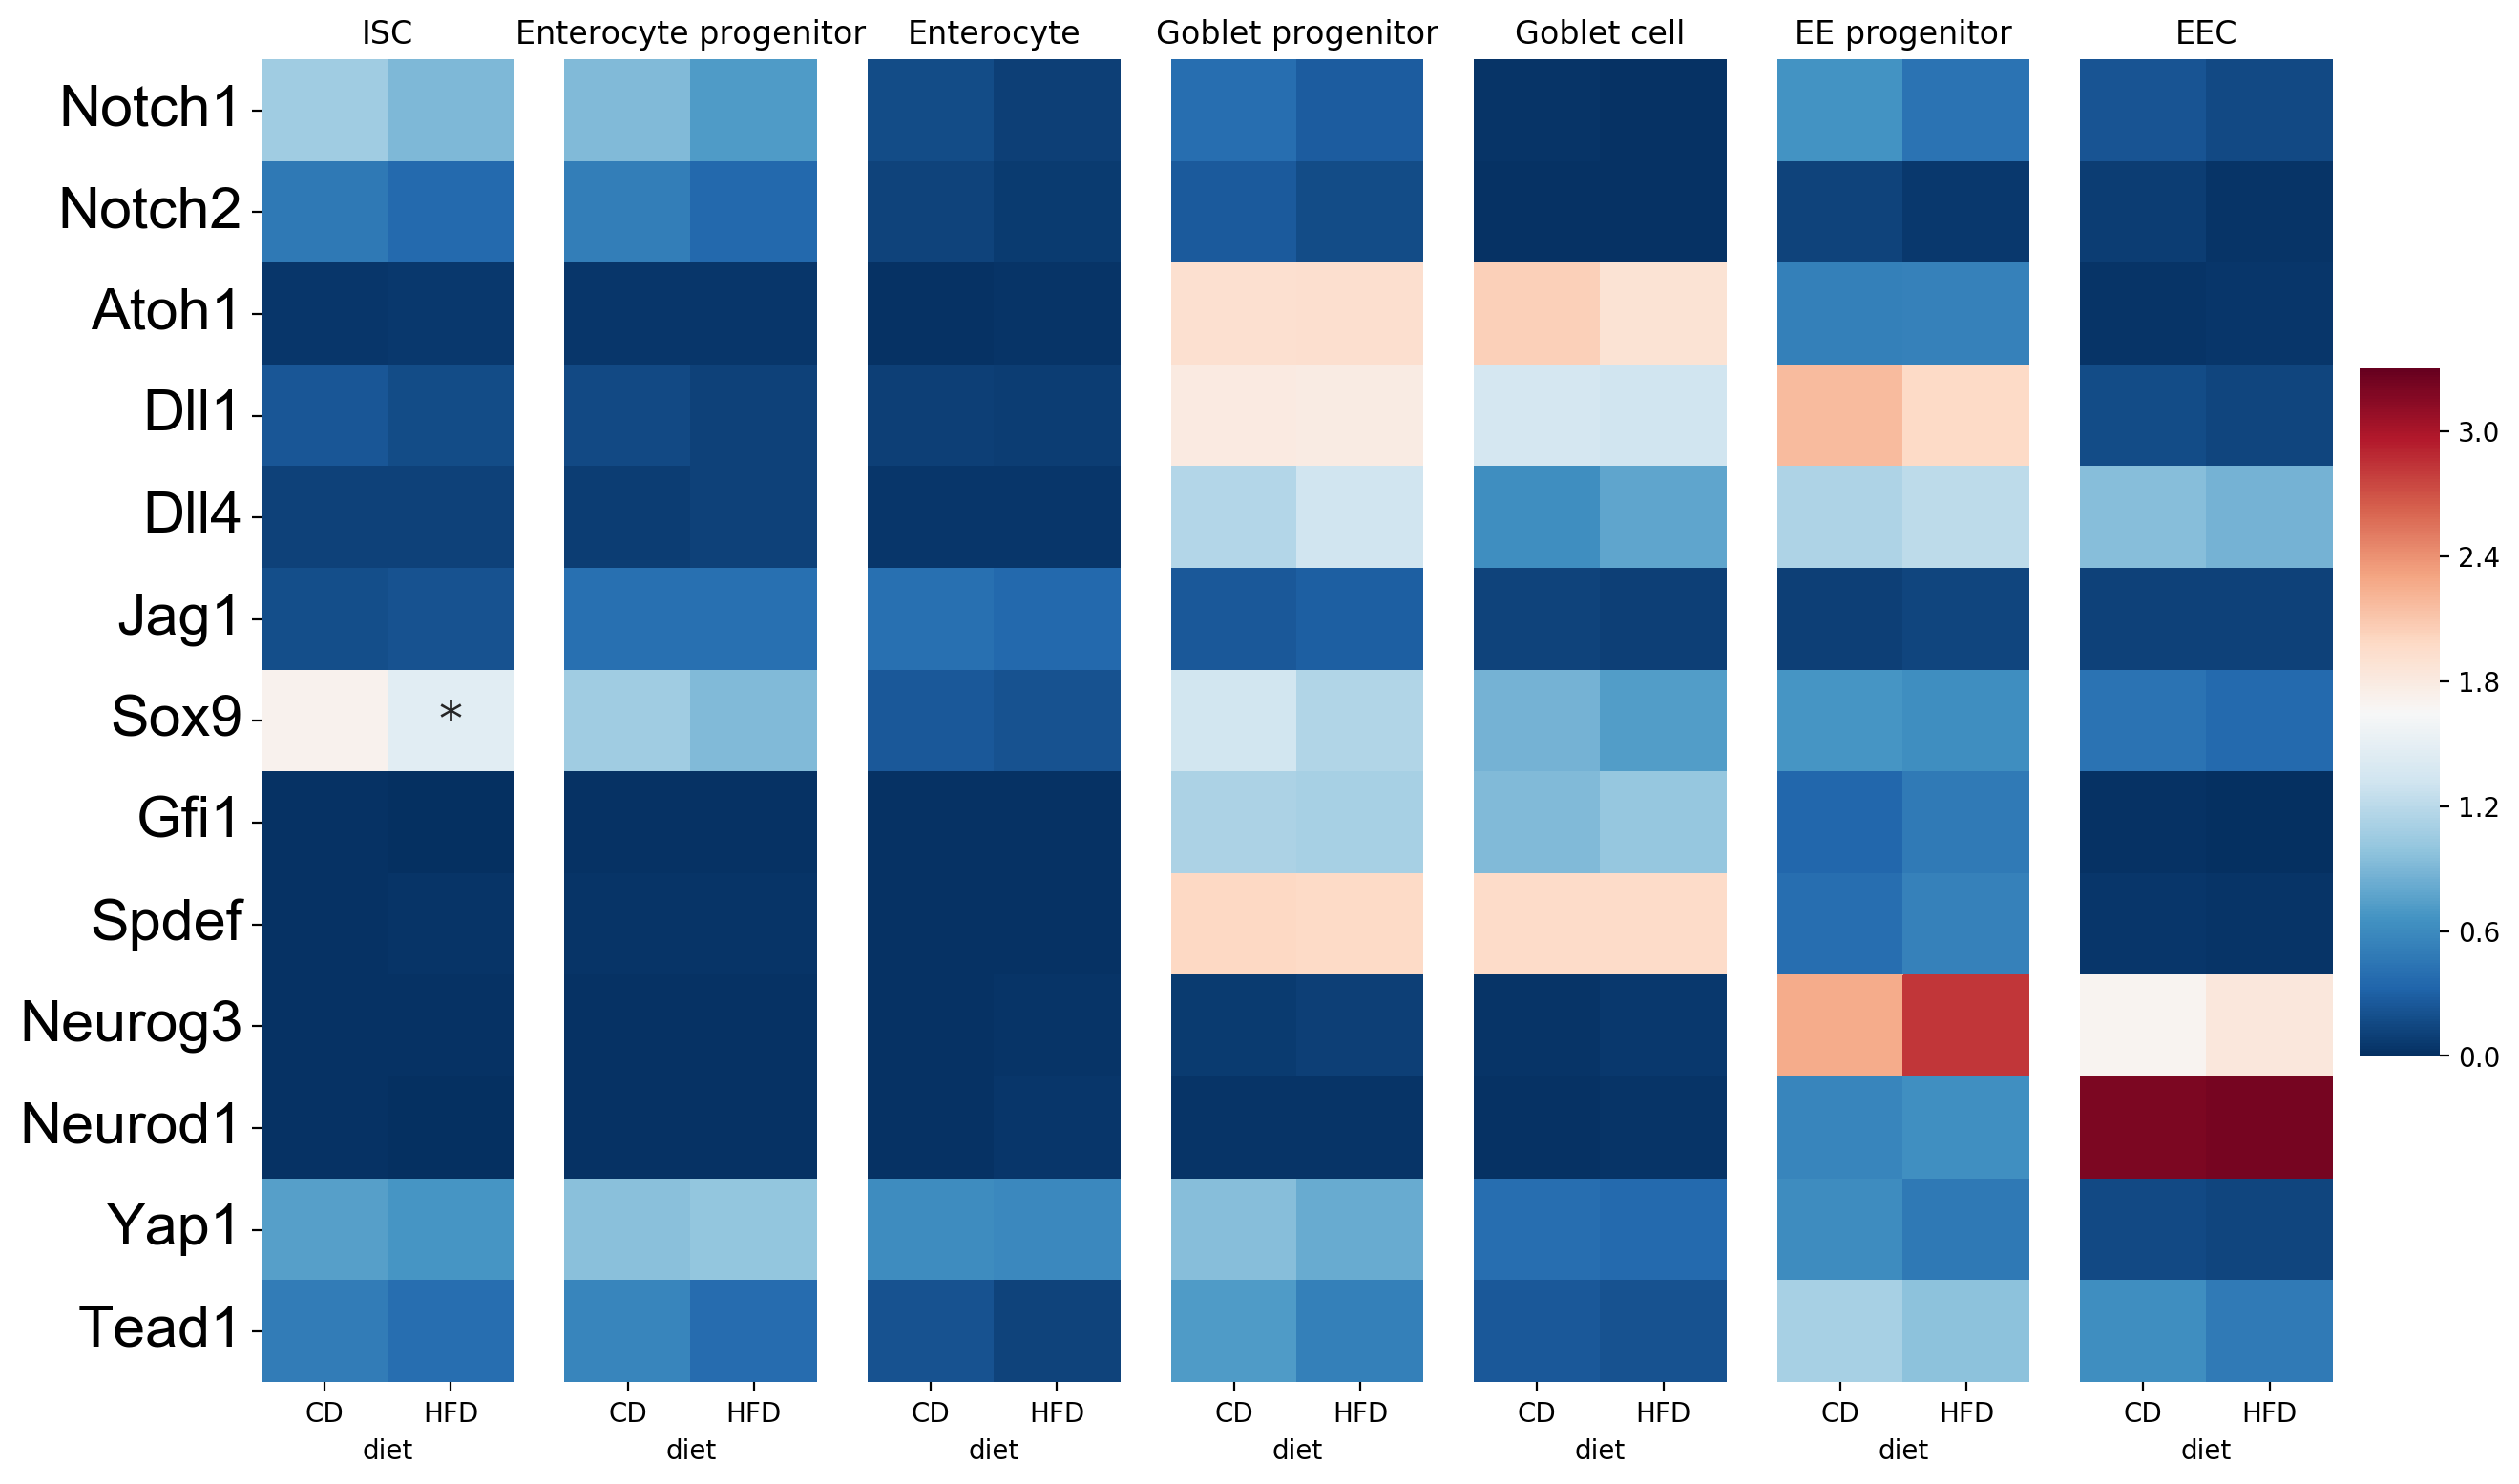

In [102]:
rcParams['figure.figsize'] = (14, 9)
fig, axs = pl.subplots(ncols=len(cats), gridspec_kw={'wspace': 0.2})

cbar_ax = fig.add_axes([.91, .3, .03, .4])

# max value for color scale

maxvalue = 3.3

for i,group in enumerate(cats):
    # subset cells and genes
    adata_sub = adata_all_scale[adata_all.obs['groups_named_prog4'].isin([group])].copy()
    adata_sub = adata_sub[:, gene_names].copy()
    
    # create dataframe
    obs_df = pd.DataFrame(adata_sub.X.toarray(), columns=adata_sub.var_names)
    obs_df['diet'] = adata_sub.obs['diet'].values
    
    # compute mean by by condition
    df_mean = obs_df.groupby(['diet']).mean()[gene_names]

    # get significantly differential genes
    try:
        # upregulated genes
        data = pd.read_excel(filename, group+'_up', index_col=0)
        ix_fc = data['logFC']>0.1
        data_up = data[ix_fc]
        ix_p = data_up['adj.P.Val']<0.01
        data_up = data_up[ix_p]
        
        # downregulated genes
        data = pd.read_excel(filename, group+'_down', index_col=0)
        ix_fc = data['logFC']<-0.1
        data_down = data[ix_fc]
        ix_p = data_down['adj.P.Val']<0.01
        data_down = data_down[ix_p]
        
        genes_up = [gene for gene in gene_names if gene in data_up.index]
        genes_down = [gene for gene in gene_names if gene in data_down.index]

        annots = np.array([['','*'] if value else ['',''] for value in np.isin(df_mean.columns, genes_up+genes_down)])
        
        sns.heatmap(df_mean.T, cmap='RdBu_r', ax=axs[i], cbar=i==0, yticklabels=i==0, cbar_ax=None if i else cbar_ax,
                    annot=annots, fmt='', annot_kws={'fontsize':18}, vmin=0,vmax=maxvalue)
        
 
        axs[i].set_title(group)
        axs[i].set_ylabel('')
        axs[i].set_yticklabels(df_mean.columns,fontdict={'verticalalignment': 'center','rotation':0,'fontsize':22,'fontname':'Arial'})

        del annots
        
    except XLRDError:
        pass
    
    if 'annots' not in locals():
        sns.heatmap(df_mean.T, cmap='RdBu_r', ax=axs[i], cbar=i==0, yticklabels=i==0, cbar_ax=None if i else cbar_ax, vmin=0, vmax=maxvalue)
     
    axs[i].set_title(group)
    axs[i].set_ylabel('')
       
    del obs_df
    
fig.tight_layout(rect=[0, 0, .9, 1])
pl.savefig('./figures/Heatmap_significance_lineage.pdf', dpi=300, format='pdf')
pl.show()

pl.rcParams.update(pl.rcParamsDefault)